<a href="https://colab.research.google.com/github/miguelruor/GeneticEvolution/blob/main/GeneticEvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we model genetic evolution via two models: continuous-time random walks and quantum walks  (Venegas-Andraca 2012), both over a given genotype space (Wagner, 2011). This work is an extension of Santiago et al. 2021. 

We compute hitting times to novel phenotypes in both models in every simulation.

# Libraries

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import expm
from scipy.sparse import csr_matrix
from scipy.linalg import norm
from scipy.sparse.linalg import expm_multiply
from scipy.stats import expon
import seaborn as sns
import pandas as pd
import json
import uuid
import datetime

In [ ]:
from pathlib import Path

# Function to read all name files in a folder
def ls(ruta = Path.cwd()): 
    return [arch.name for arch in Path(ruta).iterdir() if arch.is_file()]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importation of graphs and global variables

In [ ]:
dir_file_2phen = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_2phen/genotype_space/gspace.gml"
dir_file_4phen = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/genotype_space/gspace.gml"

In [ ]:
gspace_2phen = nx.read_gml(dir_file_2phen, label='id')
gspace_4phen = nx.read_gml(dir_file_4phen, label='id')

In [ ]:
url_data_visualization = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/data visualization/"

In [ ]:
url_evolution_paths = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_QW"
url_simulations_results = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_simulations_results.csv"
url_parameters = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_parameters.csv"

In [ ]:
url_parameters_c = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_parameters.csv"
url_evolution_paths_c = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/"
url_simulations_results_c = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_simulations_results.csv"

# Identifying genotype networks

### Maximum number of steps to find a novel phenotype

In [ ]:
gspace_2phen.nodes[0].keys()

dict_keys(['label', 'sequence', 'phenotypeName', 'phenotypeIndex', 'node_novelPhen', 'steps_novelPhen', 'nodes_novelPhen'])

In [ ]:
gspace_2phen.nodes[0]['steps_novelPhen']

1

In [ ]:
maxSteps = 0

for v in gspace_4phen.nodes:
  if gspace_4phen.nodes[v]['steps_novelPhen'] != 'infinity' and gspace_4phen.nodes[v]['steps_novelPhen'] > maxSteps:
    maxSteps = gspace_4phen.nodes[v]['steps_novelPhen']
  
maxSteps

5

In [ ]:
maxSteps_2 = 0

for v in gspace_2phen.nodes:
  if gspace_2phen.nodes[v]['steps_novelPhen'] != 'infinity' and gspace_2phen.nodes[v]['steps_novelPhen'] > maxSteps_2:
    maxSteps_2 = gspace_2phen.nodes[v]['steps_novelPhen']
  
maxSteps_2

8

Genotypes at n steps away from a novel phenotype, n=1,2,3,..., maxSteps (four phenotype graph)

In [ ]:
vertex_nSteps = {}
for n in range(1, maxSteps+1):
  vertex_nSteps[n] = []
vertex_nSteps['infinity'] = []

for v in gspace_4phen.nodes:
  vertex_nSteps[gspace_4phen.nodes[v]['steps_novelPhen']].append(v)

In [ ]:
for i in vertex_nSteps:
  print("Nodos a", i, "pasos de encontrar un nuevo fenotipo: ", len(vertex_nSteps[i]))

Nodos a 1 pasos de encontrar un nuevo fenotipo:  254
Nodos a 2 pasos de encontrar un nuevo fenotipo:  205
Nodos a 3 pasos de encontrar un nuevo fenotipo:  99
Nodos a 4 pasos de encontrar un nuevo fenotipo:  18
Nodos a 5 pasos de encontrar un nuevo fenotipo:  3
Nodos a infinity pasos de encontrar un nuevo fenotipo:  0


Genotypes at n steps away from a novel phenotype, n=1,2,3,..., maxSteps (two phenotype graph)

In [ ]:
vertex_nSteps_2 = {}
for n in range(1, maxSteps_2+1):
  vertex_nSteps_2[n] = []
vertex_nSteps_2['infinity'] = []

for v in gspace_2phen.nodes:
  vertex_nSteps_2[gspace_2phen.nodes[v]['steps_novelPhen']].append(v)

In [ ]:
for i in vertex_nSteps_2:
  print("Nodos a", i, "pasos de encontrar un nuevo fenotipo: ", len(vertex_nSteps_2[i]))

Nodos a 1 pasos de encontrar un nuevo fenotipo:  87
Nodos a 2 pasos de encontrar un nuevo fenotipo:  136
Nodos a 3 pasos de encontrar un nuevo fenotipo:  114
Nodos a 4 pasos de encontrar un nuevo fenotipo:  36
Nodos a 5 pasos de encontrar un nuevo fenotipo:  12
Nodos a 6 pasos de encontrar un nuevo fenotipo:  6
Nodos a 7 pasos de encontrar un nuevo fenotipo:  4
Nodos a 8 pasos de encontrar un nuevo fenotipo:  1
Nodos a infinity pasos de encontrar un nuevo fenotipo:  0


### Identifying genotype networks

In [ ]:
phenIndex_4phen = {'Ascl2': 0, 'Bbx': 1, 'Foxa2': 2, 'Mafb': 3}
phenIndex_2phen = {'Bbx': 0, 'Foxa2': 1}

In [ ]:
genotype_networks_4phen = {'Ascl2': {}, 'Bbx': {}, 
                           'Foxa2': {}, 'Mafb': {}}
genotype_networks_2phen = {'Bbx': {}, 'Foxa2': {}}

In [ ]:
for phen in phenIndex_4phen:
  genotype_networks_4phen[phen]['phenotype'] = phen
  genotype_networks_4phen[phen]['phenotype_id'] = phenIndex_4phen[phen]
  genotype_networks_4phen[phen]['nodes'] = []
  genotype_networks_4phen[phen]['total_nodes'] = 0

for phen in phenIndex_2phen:
  genotype_networks_2phen[phen]['phenotype'] = phen
  genotype_networks_2phen[phen]['phenotype_id'] = phenIndex_2phen[phen]
  genotype_networks_2phen[phen]['nodes'] = []
  genotype_networks_2phen[phen]['total_nodes'] = 0

In [ ]:
for v in gspace_4phen.nodes:
  for phen in gspace_4phen.nodes[v]['phenotypeName']:
    genotype_networks_4phen[phen]['nodes'].append(v)
    genotype_networks_4phen[phen]['total_nodes'] += 1

for v in gspace_2phen.nodes:
  for phen in gspace_2phen.nodes[v]['phenotypeName']:
    genotype_networks_2phen[phen]['nodes'].append(v)
    genotype_networks_2phen[phen]['total_nodes'] += 1

In [ ]:
print(genotype_networks_2phen['Foxa2']['total_nodes'])
print(genotype_networks_2phen['Bbx']['total_nodes'])
print(len(gspace_2phen.nodes))
print(len(set(genotype_networks_2phen['Foxa2']['nodes']).intersection(set(genotype_networks_2phen['Bbx']['nodes']))))

325
71
396
0


In [ ]:
print(genotype_networks_4phen['Mafb']['total_nodes'])
print(genotype_networks_4phen['Ascl2']['total_nodes'])
print(genotype_networks_4phen['Foxa2']['total_nodes'])
print(genotype_networks_4phen['Bbx']['total_nodes'])
print(len(gspace_4phen.nodes))

112
76
328
74
579


In [ ]:
genotype_networks_4phen['Mafb'].keys()

dict_keys(['phenotype', 'phenotype_id', 'nodes', 'total_nodes'])

In [ ]:
gspace_4phen.nodes[0].keys()

dict_keys(['label', 'sequence', 'phenotypeName', 'phenotypeIndex', 'node_novelPhen', 'steps_novelPhen', 'nodes_novelPhen'])

In [ ]:
for phen in phenIndex_4phen:
  for n in vertex_nSteps:
    vertex_nSteps_phen = set(vertex_nSteps[n]).intersection(set(genotype_networks_4phen[phen]['nodes']))
    print("Nodes in genotype network of", phen, "at", n, "steps from novel phenotype:", len(vertex_nSteps_phen))

Nodes in genotype network of Ascl2 at 1 steps from novel phenotype: 4
Nodes in genotype network of Ascl2 at 2 steps from novel phenotype: 19
Nodes in genotype network of Ascl2 at 3 steps from novel phenotype: 36
Nodes in genotype network of Ascl2 at 4 steps from novel phenotype: 15
Nodes in genotype network of Ascl2 at 5 steps from novel phenotype: 2
Nodes in genotype network of Ascl2 at infinity steps from novel phenotype: 0
Nodes in genotype network of Bbx at 1 steps from novel phenotype: 38
Nodes in genotype network of Bbx at 2 steps from novel phenotype: 27
Nodes in genotype network of Bbx at 3 steps from novel phenotype: 8
Nodes in genotype network of Bbx at 4 steps from novel phenotype: 1
Nodes in genotype network of Bbx at 5 steps from novel phenotype: 0
Nodes in genotype network of Bbx at infinity steps from novel phenotype: 0
Nodes in genotype network of Foxa2 at 1 steps from novel phenotype: 147
Nodes in genotype network of Foxa2 at 2 steps from novel phenotype: 131
Nodes in 

In [ ]:
for phen in phenIndex_2phen:
  for n in vertex_nSteps_2:
    vertex_nSteps_phen = set(vertex_nSteps_2[n]).intersection(set(genotype_networks_2phen[phen]['nodes']))
    print("Nodes in genotype network of", phen, "at", n, "steps from novel phenotype:", len(vertex_nSteps_phen))

Nodes in genotype network of Bbx at 1 steps from novel phenotype: 37
Nodes in genotype network of Bbx at 2 steps from novel phenotype: 25
Nodes in genotype network of Bbx at 3 steps from novel phenotype: 8
Nodes in genotype network of Bbx at 4 steps from novel phenotype: 1
Nodes in genotype network of Bbx at 5 steps from novel phenotype: 0
Nodes in genotype network of Bbx at 6 steps from novel phenotype: 0
Nodes in genotype network of Bbx at 7 steps from novel phenotype: 0
Nodes in genotype network of Bbx at 8 steps from novel phenotype: 0
Nodes in genotype network of Bbx at infinity steps from novel phenotype: 0
Nodes in genotype network of Foxa2 at 1 steps from novel phenotype: 50
Nodes in genotype network of Foxa2 at 2 steps from novel phenotype: 111
Nodes in genotype network of Foxa2 at 3 steps from novel phenotype: 106
Nodes in genotype network of Foxa2 at 4 steps from novel phenotype: 35
Nodes in genotype network of Foxa2 at 5 steps from novel phenotype: 12
Nodes in genotype netw

In [ ]:
for v in genotype_networks_4phen['Ascl2']['nodes']:
  if gspace_4phen.nodes[v]['sequence'] == 'CAGCTGAC':
    print(v)

10


In [ ]:
for v in genotype_networks_4phen['Mafb']['nodes']:
  if gspace_4phen.nodes[v]['sequence'] == 'CTGCTGAC':
    print(v)

542


In [ ]:
phenotypes = genotype_networks_4phen.keys()

# Auxiliar functions

In [ ]:
def randomInitialGenotype(gspace, size=1):
  if size == 1:
    return np.random.choice(gspace.nodes)
  else:
    return np.random.choice(gspace.nodes, size=size)

# function that returns a random genotype in a genotype network
def randomInitialGenotypeFromGenotypeNetwork(genotype_network):
  return np.random.choice(genotype_network['nodes'])

# function that returns a random genotype in a genotype network at n steps of finding a novel phenotype
def randomInitialGenotypeNSteps(genotype_network, n):
  return np.random.choice(list(set(vertex_nSteps[n]).intersection(set(genotype_network['nodes'])))) 

def randomPhenotype(phenotypes):
  return np.random.choice(phenotypes)

# index of the sequence given
def sequenceIndex(sequence, gspace):
  for v in gspace.nodes:
    if sequence == gspace.nodes[v]['sequence']:
      return v

Function to obtain the distance between two DNA sequences

In [ ]:
def distance(sequence1, sequence2):
  dist = 0
  N = len(sequence1)

  for i in range(N):
    if sequence1[i] != sequence2[i]:
      dist += 1

  return dist

# Quantum genetic evolution (CTQW)

### Auxiliar functions

Function to obtain the Hamiltonian associated to a given graph and the mutation rate

In [ ]:
def giveMeHamiltonian(G, gamma, typeMatrix="laplacian"):
  # typeMatrix could be "adjacency" to use the adjacency matrix based Hamiltoninan 
  # or "laplacian" (default) to use the Laplacian matrix based Hamiltonian
  # gamma is the mutation rate 

  if typeMatrix == "adjacency":
    A = nx.adjacency_matrix(G)
  else:
    A = nx.laplacian_matrix(G)

  H = -gamma* A

  return H

Function to calculate the i-th canonical vector in $C^n$

In [ ]:
def canonical_vector(i, n):
  # i-esimo vector canonico en C^n
  ei = np.zeros(n)
  ei[i] = 1.0
  return ei

Function to simulate a measurement of the quantum walk

In [ ]:
def measurement(state, basis):
  # state is a vector in C^N

  qprobs = [abs(state[v])**2 for v in basis]
  collapse = np.random.choice(basis, p=qprobs)

  return collapse

In [ ]:
state = [(0.5)**(0.5), (0.5j)**(0.5)]
basis = [0, 1]
print(measurement(state, basis))

0


Read all evolution paths or a list given

In [ ]:
def allEvolutionPaths():
  # return in a dictionary with keys the simulations index and saves the evolution paths
  all_evolution_paths = {}
  files = ls("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_QW/")

  for file in files:
    all_evolution_paths[int(file[:-4])] = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/"
      +"evolution_paths_QW/"+file, index_col=0)
    
  return all_evolution_paths

def evolutionPaths(simulation_indices):
  # return in a dictionary with keys the simulations index and saves the evolution paths
  evolution_paths = {}

  for ind in simulation_indices:
    evolution_paths[ind] = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_QW/"+
                               str(ind)+".csv", index_col=0)
    
  return evolution_paths

### Reading last results



In [ ]:
#parameters = pd.DataFrame(columns=['initial_phen', 'initial_gen', 'initial_gen_index', 'max_measurements', 'measurement_rate', 'transition_rate', 'max_simulation_time])

In [ ]:
#estimations_results = pd.DataFrame(columns=['tau_Ascl2_prom (seconds)', 'tau_Ascl2_prom (days)', 'N_Ascl2_prom', 
#                  'tau_Bbx_prom (seconds)', 'tau_Bbx_prom (days)', 'N_Bbx_prom', 'tau_Mafb_prom (seconds)', 
#                  'tau_Mafb_prom (days)', 'N_Mafb_prom', 'tau_Foxa2_prom (seconds)', 'tau_Foxa2_prom (days)', 'N_Foxa2_prom'])

#simulations_results = pd.DataFrame(columns =['parameters_index', 'tau_Ascl2', "tau_Bbx", "tau_Foxa2", "tau_Mafb", 'N_Ascl2', 
#                  "N_Bbx", "N_Foxa2", "N_Mafb"])

In [ ]:
parameters = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_parameters.csv", index_col=0)
simulations_results = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_simulations_results.csv", index_col=0)
estimations_results = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_estimation_results.csv", index_col=0)

In [ ]:
simulations_results.tail(20)

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb,simulation time
685,246,7.325196e+05,3231.253926,1502.012883,0.0,1211.0,6.0,4.0,0.0,1.000034e+06
686,246,2.985444e+05,41868.383247,767.605878,0.0,521.0,66.0,2.0,0.0,1.000718e+06
687,246,5.819345e+04,184613.186514,873.166324,0.0,103.0,313.0,1.0,0.0,1.000277e+06
688,246,3.723078e+04,202593.706698,2624.010997,0.0,56.0,319.0,1.0,0.0,1.000563e+06
689,246,1.856744e+05,41472.785505,1245.510851,0.0,302.0,73.0,2.0,0.0,1.001372e+06
690,246,8.678243e+05,110349.912272,2820.203537,0.0,1393.0,185.0,5.0,0.0,1.000496e+06
691,247,5.932072e+04,69048.532892,2856.531363,0.0,98.0,114.0,3.0,0.0,1.000643e+06
692,247,7.236659e+04,13044.735421,1769.131309,0.0,113.0,19.0,5.0,0.0,1.001576e+06
693,247,1.176508e+05,68480.071984,1852.878126,0.0,214.0,124.0,6.0,0.0,1.000451e+06
694,247,1.000820e+06,4048.454817,932.157849,0.0,-1.0,3.0,1.0,0.0,1.000820e+06


In [ ]:
estimations_results

,tau_Ascl2_prom (seconds),tau_Ascl2_prom (days),N_Ascl2_prom,tau_Bbx_prom (seconds),tau_Bbx_prom (days),N_Bbx_prom,tau_Mafb_prom (seconds),tau_Mafb_prom (days),N_Mafb_prom,tau_Foxa2_prom (seconds),tau_Foxa2_prom (days),N_Foxa2_prom


In [ ]:
parameters

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate,max_simulation_time
0,Mafb,ATGAAAAA,552,5000.0,50.0,0.0010,-1
1,Ascl2,CAGCTGCG,57,5000.0,50.0,0.0001,-1
2,Bbx,TTATGAAA,128,5000.0,50.0,0.0001,-1
3,Ascl2,ACAGCTGT,44,5000.0,50.0,0.0001,-1
4,Mafb,ATTTGCAA,575,5000.0,50.0,0.0001,-1
...,...,...,...,...,...,...,...
244,Mafb,GCATATGC,511,-1.0,500.0,0.0010,1000000
245,Mafb,GCATATGC,511,-1.0,550.0,0.0010,1000000
246,Mafb,GCATATGC,511,-1.0,600.0,0.0010,1000000
247,Mafb,GCATATGC,511,-1.0,650.0,0.0010,1000000


## Simulation algorithm

In [ ]:
def simulation_qw(gspace, phenotypes, url_evolution_paths, url_simulations_results):
  global simulations_results
  global parameters_index
  
  if new_parameters:
    parameters_index = len(parameters)-1

  M = len(gspace.nodes)

  tau = {} # estimation of tau (hitting time) for every phenotype 
  # Time it takes quantum walk to find given phenotype

  N = {} # estimation of N 
  # number of jumps the random walk takes to find a genotype with a new phenotype

  phenotype_frequency = {} # for saving phenotype frequency in evolution path
  evolution_path_columns = ["holding time", "accumulated time", "genotype index", "genotype sequence"]

  for phen in phenotypes:
    evolution_path_columns.append(phen + " freq.")

  no_measurement = 0
  time = 0
  mutation_time = 0

  #initialization
  for phen in phenotypes:
    tau[phen] = -1
    N[phen] = -1

  evolution_path = pd.DataFrame(columns=evolution_path_columns) # indices of genotypes of the evolution 
  actual_state = initial_genotype 

  evolution_path_aux = {}
  # phenotypes of actual state
  phenotypes_actual_state = gspace.nodes[actual_state]['phenotypeName']
  # the other phenotypes in genotype space
  phenotypes_actual_state_complement = set(phenotypes).difference(set(phenotypes_actual_state))

  for phen in phenotypes_actual_state:
    evolution_path_aux[phen+" freq."] = 1.0

  for phen in phenotypes_actual_state_complement:
    evolution_path_aux[phen+" freq."] = 0.0

  evolution_path_aux['holding time'] = 0.0
  evolution_path_aux['accumulated time'] = 0.0
  evolution_path_aux['genotype index'] = int(initial_genotype)
  evolution_path_aux['genotype sequence'] = gspace.nodes[initial_genotype]['sequence']
  evolution_path_aux['is mutation'] = False
  evolution_path_aux['mutation time'] = -1

  evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

  variable = 0

  if max_measurements < 0:
    max_variable = max_simulation_time
  else:
    max_variable = max_measurements

  # The following while loop ends when 'variable' is greater or equal than 'max_variable'. 'variable' could be the number of measurements or the accumulated time 
  # of the simulation, depending of the parameters
  while variable < max_variable:
    for phen in phenotypes_actual_state:
      if tau[phen] < 0: # update hitting times of novel phenotypes
        tau[phen] = time
        N[phen] = no_measurement
      
    T = expon.rvs(scale=measurement_rate, size=1)[0] # sample of exponential distribution with scale parameter measurement_rate

    evolution_path_aux['holding time'] = T
    evolution_path_aux['accumulated time'] = T+time
    
    # evolving quantum walk
    actual_state_vec = canonical_vector(actual_state, M) # vector representing genotype actual_state
    actual_state_vec = expm_multiply(-1j*T*H, actual_state_vec) # evolve quantum walk until time T with actual_state as initial state
    measurement_result = measurement(actual_state_vec, gspace.nodes)

    if measurement_result != actual_state:
      evolution_path_aux['is mutation'] = True
      evolution_path_aux['mutation time'] = mutation_time
      mutation_time = 0
    else:
      evolution_path_aux['is mutation'] = False
      evolution_path_aux['mutation time'] = -1
      mutation_time += T

    actual_state = measurement_result

    evolution_path_aux['genotype index'] = actual_state
    evolution_path_aux['genotype sequence'] = gspace.nodes[actual_state]['sequence']

    # phenotypes of actual state
    phenotypes_actual_state = gspace.nodes[actual_state]['phenotypeName']
    # the other phenotypes in genotype space
    phenotypes_actual_state_complement = set(phenotypes).difference(set(phenotypes_actual_state))

    for phen in phenotypes_actual_state:
      evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][no_measurement]*no_measurement+1)/(no_measurement+1)

    for phen in phenotypes_actual_state_complement:
      evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][no_measurement]*no_measurement)/(no_measurement+1)

    evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

    time += T
    no_measurement += 1

    if max_measurements < 0:
      variable = time
    else:
      variable = no_measurement
    
    if no_measurement % 1000 == 0:
      print("Measurement number", no_measurement)
      print("Accumulated time", time)
      
  simulations_results_aux = {'parameters_index': int(parameters_index), 'simulation time': time}

  for phen in phenotypes:
    simulations_results_aux['tau_'+phen] = tau[phen] if tau[phen]>=0.0 else time
    simulations_results_aux['N_'+phen] = N[phen] if N[phen]>=0 else max_measurements

  simulations_results = simulations_results.append(simulations_results_aux, ignore_index=True)
  
  evolution_path.to_csv(url_evolution_paths+str(len(simulations_results)-1)+".csv")
    
  # writing results of simulations  
  simulations_results.to_csv(url_simulations_results)

Function to perform simulations with random initial genotypes

In [ ]:
def randomSimulations_QW(simulations, gspace, phenotypes, url_parameters, url_evolution_paths, url_simulations_results):
  global parameters
  global initial_genotype
  global initial_sequence
  global initial_phen

  np.random.seed(2021)
  initial_genotypes = randomInitialGenotype(gspace_4phen, simulations)

  for i in range(simulations):
    print("Start of random simulation", i+1,"/",simulations)
    initial_genotype = initial_genotypes[i]
    initial_sequence = gspace.nodes[initial_genotype]['sequence']
    initial_phen = gspace.nodes[initial_genotype]['phenotypeName'][0]

    parameters = parameters.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': initial_genotype, 
                                'max_measurements': max_measurements, 'measurement_rate': measurement_rate, 'transition_rate': gamma, 
                                'max_simulation_time': max_simulation_time}, 
                               ignore_index=True)
    parameters.to_csv(url_parameters)

    simulation_qw(gspace, phenotypes, url_evolution_paths, url_simulations_results)

## Simulations

### Parameters

In [ ]:
simulations = 10 # number of simulations
np.random.seed(2021)

#### Old parameters

In [ ]:
parameters.tail(20)

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate,max_simulation_time
194,Foxa2,GACAAACA,152,-1.0,500.0,0.001,1000000
195,Foxa2,AAAACAAT,396,-1.0,500.0,0.001,1000000
196,Mafb,TGTGAAAA,502,-1.0,500.0,0.001,1000000
197,Foxa2,TATACATA,198,-1.0,500.0,0.001,1000000
198,Bbx,TGAAAGAA,102,-1.0,500.0,0.001,1000000
199,Ascl2,CACCTGTA,70,-1.0,500.0,0.001,1000000
200,Mafb,AGTGCTGA,545,-1.0,500.0,0.001,1000000
201,Foxa2,ACACAAAC,257,-1.0,500.0,0.001,1000000
202,Foxa2,ATTGTGTA,366,-1.0,500.0,0.001,1000000
203,Mafb,AAGCAAAA,481,-1.0,500.0,0.001,1000000


In [ ]:
parameters_index = 191

In [ ]:
new_parameters = False
max_measurements = parameters.loc[parameters_index]['max_measurements'] # maximum number of measurements in a simulation. -1 if you want to take into account a maximum simulation time instead
measurement_rate = parameters.loc[parameters_index]['measurement_rate'] # This is equal to the average decoherence time of the system. 
max_simulation_time = parameters.loc[parameters_index]['max_simulation_time'] # maximum simulation time in seconds. -1 if you want to take into account a maximum number of measurements instead
# McFadden and Al-Khalili (1999) estimated that it is between 1-100 seconds or more
gamma = parameters.loc[parameters_index]['transition_rate'] # transition rate between neighbor nodes
initial_phen = parameters.loc[parameters_index]['initial_phen']
initial_genotype = parameters.loc[parameters_index]['initial_gen_index']
print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

511
['Mafb']


#### New parameters

Required parameters

In [ ]:
new_parameters = True
max_measurements = -1 # maximum number of measurements in a simulation. -1 if you want to take into account a maximum simulation time instead
max_simulation_time = 10**6 # maximum simulation time in seconds. -1 if you want to take into account a maximum number of measurements instead
measurement_rate = 100 # This is equal to the average decoherence time of the system. 
# McFadden and Al-Khalili (1999) estimated that it is between 1-100 seconds or more
gamma = 10**(-3) # transition rate between neighbor nodes

Optional parameters </br>

You can choose simulations with random initial genotypes with randomSimulations_QW. If this is the case, do not run this cell

In [ ]:
initial_genotype = 0
initial_phen = gspace_4phen.nodes[initial_genotype]['phenotypeName'][0]
initial_sequence = gspace_4phen.nodes[initial_genotype]['sequence']

# Uncomment the following lines if you want to choose a genotype by its sequence. initial_phen must have its phenotype
# initial sequence = "AAAAAAAA"
# initial_genotype = sequenceIndex(initial_sequence)

print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

parameters = parameters.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': initial_genotype, 
                                'max_measurements': max_measurements, 'measurement_rate': measurement_rate, 'transition_rate': gamma,
                                'max_simulation_time': max_simulation_time}, 
                               ignore_index=True)
parameters.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_parameters.csv")

0
['Ascl2']


#### Loading fix parameters

In [ ]:
H = giveMeHamiltonian(gspace_4phen, gamma)
M = gspace_4phen.number_of_nodes() # number of nodes and dimension of Hilbert space

### Simulations

#### Simulation with fixed parameters

In [ ]:
for i in range(simulations):
  print(f'Start of simulation {i+1}/{simulations}')
  simulation_qw(gspace_4phen, genotype_networks_4phen.keys(), url_evolution_paths, url_simulations_results)

#### Simulations with random initial genotype

In [ ]:
randomSimulations_QW(simulations, gspace_4phen, genotype_networks_4phen.keys(), url_parameters, url_evolution_paths, 
                  url_simulations_results)
simulations_results

# Classic evolution (CTRW)

### Auxiliar functions

In [ ]:
def infinitesimalGenerator(G, gamma):
  # gamma is the mutation rate 

  A = nx.laplacian_matrix(G)
  H = -gamma* A

  return H

In [ ]:
def nextState(states, i, Q):
  # choose next state to jump to from the i-th row of the jump process transition matrix
  # states are the set of state of the random walk
  # i is the actual state
  # Q is the infinitesimal generator of the continuous random walk
  probs = [-Q[i, j]/Q[i, i] for j in states]
  probs[i] = 0 

  return np.random.choice(states, p = probs)

Read all evolution paths or a given one

In [ ]:
def allEvolutionPaths_c():
  # return in a dictionary with keys the simulations index and saves the evolution paths
  all_evolution_paths = {}
  files = ls("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/")

  for file in files:
    all_evolution_paths[int(file[:-4])] = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/"+
                               file, index_col=0)
    
  return all_evolution_paths

def evolutionPaths_c(simulation_indices):
  evolution_paths = {}

  for ind in simulation_indices:
    evolution_paths[ind] = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/"+
                               str(ind)+".csv", index_col=0)
  
  return evolution_paths

### Reading last results



In [ ]:
#parameters_c = pd.DataFrame(columns=['initial_phen', 'initial_gen', 'initial_gen_index', 'max_jumps', 'transition_rate', 'max_simulation_time'])

In [ ]:
#estimations_results_c = pd.DataFrame(columns=['tau_Ascl2_prom (seconds)', 'tau_Ascl2_prom (days)', 'N_Ascl2_prom', 
#                  'tau_Bbx_prom (seconds)', 'tau_Bbx_prom (days)', 'N_Bbx_prom', 'tau_Mafb_prom (seconds)', 
#                  'tau_Mafb_prom (days)', 'N_Mafb_prom', 'tau_Foxa2_prom (seconds)', 'tau_Foxa2_prom (days)', 'N_Foxa2_prom'])

#simulations_results_c = pd.DataFrame(columns =['parameters_index', 'tau_Ascl2', "tau_Bbx", "tau_Foxa2", "tau_Mafb", 'N_Ascl2', 
#                  "N_Bbx", "N_Foxa2", "N_Mafb"])

In [ ]:
parameters_c = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_parameters.csv", index_col=0)
simulations_results_c = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_simulations_results.csv", index_col=0)
estimations_results_c = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_estimation_results.csv", index_col=0)

In [ ]:
simulations_results_c

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb,simulation time
0,0.0,84612.090649,6920.023048,321.125575,0.0,414.0,40.0,2.0,0.0,1.034161e+06
1,0.0,112969.379860,21036.119062,1938.534737,0.0,531.0,95.0,7.0,0.0,1.018170e+06
2,0.0,554207.920083,8726.610003,3903.591836,0.0,2480.0,39.0,11.0,0.0,1.063848e+06
3,0.0,16112.915939,30034.068387,68.433303,0.0,114.0,191.0,2.0,0.0,1.046495e+06
4,0.0,36429.698176,2132.817535,1440.334812,0.0,198.0,11.0,4.0,0.0,1.025786e+06
...,...,...,...,...,...,...,...,...,...,...
219,157.0,655630.153751,2040.169697,11.363921,0.0,3000.0,8.0,1.0,0.0,1.000049e+06
220,157.0,233239.038754,812.879880,389.975362,0.0,1179.0,7.0,2.0,0.0,1.001542e+06
221,157.0,124225.605150,3304.989809,450.164589,0.0,646.0,13.0,3.0,0.0,1.000019e+06
222,157.0,46879.972284,17333.227880,344.830066,0.0,231.0,85.0,5.0,0.0,1.000176e+06


In [ ]:
estimations_results_c

,tau_Ascl2_prom (seconds),tau_Ascl2_prom (days),N_Ascl2_prom,tau_Bbx_prom (seconds),tau_Bbx_prom (days),N_Bbx_prom,tau_Mafb_prom (seconds),tau_Mafb_prom (days),N_Mafb_prom,tau_Foxa2_prom (seconds),tau_Foxa2_prom (days),N_Foxa2_prom


In [ ]:
parameters_c

,initial_phen,initial_gen,initial_gen_index,max_jumps,transition_rate,max_simulation_time
0,Mafb,ATGAAAAA,552,5000,0.001,-1
1,Bbx,TTCATGAA,116,5000,0.001,-1
2,Ascl2,CATATGTC,45,5000,0.001,-1
3,Bbx,AAATGAAT,145,5000,0.001,-1
4,Foxa2,TCAACAAA,351,5000,0.001,-1
...,...,...,...,...,...,...
153,Mafb,AAGCAAAA,481,-1,0.001,1000000
154,Foxa2,ATATAAAC,380,-1,0.001,1000000
155,Foxa2,AAACAAGC,410,-1,0.001,1000000
156,Ascl2,GCATATGC,0,-1,0.001,1000000


## Simulation algorithm

In [ ]:
def simulation_cw(gspace, phenotypes, url_evolution_paths, url_simulations_results):
  global simulations_results_c
  global parameters_index

  if new_parameters:
    parameters_index = len(parameters_c)-1

  tau = {} # estimation of tau (hitting time) for every phenotype 
  # Time it takes quantum walk to find given phenotype

  N = {} # estimation of N 
  # number of jumps the random walk takes to find a genotype with a new phenotype

  phenotype_frequency = {} # for saving phenotype frequency in evolution path
  evolution_path_columns = ["holding time", "accumulated time", "genotype index", "genotype sequence"]

  for phen in phenotypes:
    evolution_path_columns.append(phen + " freq.")

  jump = 0
  time = 0
  
  #initialization
  for phen in phenotypes:
    tau[phen] = -1
    N[phen] = -1

  evolution_path = pd.DataFrame(columns=evolution_path_columns) # indices of genotypes of the evolution 
  actual_state = initial_genotype 

  evolution_path_aux = {}
  # phenotypes of actual state
  phenotypes_actual_state = gspace.nodes[actual_state]['phenotypeName']
  # the other phenotypes in genotype space
  phenotypes_actual_state_complement = set(phenotypes).difference(set(phenotypes_actual_state))

  for phen in phenotypes_actual_state:
    evolution_path_aux[phen+" freq."] = 1.0

  for phen in phenotypes_actual_state_complement:
    evolution_path_aux[phen+" freq."] = 0.0

  evolution_path_aux['holding time'] = 0.0
  evolution_path_aux['accumulated time'] = 0.0
  evolution_path_aux['genotype index'] = int(initial_genotype)
  evolution_path_aux['genotype sequence'] = gspace.nodes[initial_genotype]['sequence']

  evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

  variable = 0

  if max_jumps < 0: 
    max_variable = max_simulation_time
  else:
    max_variable = max_jumps

  # The following while loop ends when 'variable' is greater or equal than 'max_variable'. 'variable' could be the number of measurements or the accumulated time 
  # of the simulation, depending of the parameters
  while variable < max_variable:
    for phen in phenotypes_actual_state:
      if tau[phen] < 0: # update hitting times of novel phenotypes
        tau[phen] = time
        N[phen] = jump

    T = expon.rvs(scale = -1/H[actual_state, actual_state], size=1)[0] # sample of exponential distribution

    evolution_path_aux['holding time'] = T
    evolution_path_aux['accumulated time'] = T+time

    for phen in phenotypes_actual_state:
      evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][jump]*time+T)/(time+T)

    for phen in phenotypes_actual_state_complement:
      evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][jump]*time)/(time+T)
    
    # choice next random state
    actual_state = nextState(list(gspace.nodes), actual_state, H)
    evolution_path_aux['genotype index'] = actual_state
    evolution_path_aux['genotype sequence'] = gspace.nodes[actual_state]['sequence']

    evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

    # phenotypes of actual state
    phenotypes_actual_state = gspace.nodes[actual_state]['phenotypeName']
    # the other phenotypes in genotype space
    phenotypes_actual_state_complement = set(phenotypes).difference(set(phenotypes_actual_state))
    
    time += T
    jump += 1

    if max_jumps < 0:
      variable = time
    else:
      variable = jump
    
    if jump % 1000 == 0:
      print("Jump number", jump)
      print("Accumulated time", time)
    
  simulations_results_aux = {'parameters_index': int(parameters_index), 'simulation time': time}

  for phen in phenotypes:
    simulations_results_aux['tau_'+phen] = tau[phen] if tau[phen] >= 0 else time 
    simulations_results_aux['N_'+phen] = N[phen] if N[phen]>=0 else max_jumps

  simulations_results_c = simulations_results_c.append(simulations_results_aux, ignore_index=True)
  evolution_path.to_csv(url_evolution_paths + str(len(simulations_results_c)-1) + ".csv")
    
  # writing results of simulations
  simulations_results_c.to_csv(url_simulations_results)

Function to perform simulations with random initial genotypes

In [ ]:
def randomSimulations_CW(simulations, gspace, phenotypes, url_parameters, url_evolution_paths, url_simulations_results):
  global parameters_c
  global initial_genotype
  global initial_sequence
  global initial_phen

  np.random.seed(2021)
  initial_genotypes = randomInitialGenotype(gspace_4phen, simulations)
  
  for i in range(simulations):
    print("Start of random simulation", i+1,"/",simulations)
    initial_genotype = initial_genotypes[i]
    initial_sequence = gspace.nodes[initial_genotype]['sequence']
    initial_phen = gspace.nodes[initial_genotype]['phenotypeName'][0]

    parameters_c = parameters_c.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': int(initial_genotype), 
                                'max_jumps': int(max_jumps), 'transition_rate': gamma, 'max_simulation_time': max_simulation_time}, ignore_index=True)
    parameters_c.to_csv(url_parameters)

    simulation_cw(gspace, phenotypes, url_evolution_paths, url_simulations_results)

## Simulations

### Parameters

In [ ]:
simulations = 10
np.random.seed(2021)

#### Old parameters

In [ ]:
parameters_c.tail(40)

,initial_phen,initial_gen,initial_gen_index,max_jumps,transition_rate,max_simulation_time
117,Bbx,ATGAATTG,87,-1,0.001,1000000
118,Foxa2,CTATTTAC,395,-1,0.001,1000000
119,Mafb,TGAAAAAA,533,-1,0.001,1000000
120,Ascl2,CATCTGTA,18,-1,0.001,1000000
121,Foxa2,ATTTGTTA,354,-1,0.001,1000000
122,Foxa2,GTAAACAA,280,-1,0.001,1000000
123,Foxa2,TAAGTAAA,472,-1,0.001,1000000
124,Foxa2,TATTGACA,264,-1,0.001,1000000
125,Foxa2,AATATTGA,193,-1,0.001,1000000
126,Mafb,CGTAAGCA,480,-1,0.001,1000000


In [ ]:
parameters_index = 141

In [ ]:
new_parameters = False
max_jumps = parameters_c.loc[parameters_index]['max_jumps'] # maximum number of jumps in a simulation. -1 if you want to take into account a maximum simulation time instead
max_simulation_time = parameters_c.loc[parameters_index]['max_simulation_time'] # maximum time of simulation. -1 if you want to take into account a maximum number of jumps instead
gamma = parameters_c.loc[parameters_index]['transition_rate'] # transition rate between neighbor nodes
initial_phen = parameters_c.loc[parameters_index]['initial_phen']
initial_genotype = parameters_c.loc[parameters_index]['initial_gen_index']
print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

511
['Mafb']


#### New parameters

Required paramaters

In [ ]:
max_jumps = -1 # maximum number of jumps in a simulation. -1 if you want to take into account a maximum simulation time instead
max_simulation_time = 10**6 # maximum time of simulation. -1 if you want to take into account a maximum number of jumps instead
# McFadden and Al-Khalili (1999) estimated that it is between 1-100 seconds or more
gamma = 10**(-3) # transition rate between neighbor nodes
new_parameters = True

Optional parameters </br>

You can choose simulations with random initial genotypes with randomSimulations_CW. If this is the case, do not run this cell

In [ ]:
initial_genotype = 0
initial_sequence = gspace_4phen.nodes[initial_genotype]['sequence']
initial_phen = gspace_4phen.nodes[initial_genotype]['phenotypeName'][0]

# Uncomment the following lines if you want to choose a genotype by its sequence. initial_phen must have its phenotype
#initial_sequence = "ACAAAAAA"
#initial_genotype = sequenceIndex(initial_sequence)

print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

parameters_c = parameters_c.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': int(initial_genotype), 
                                'max_jumps': int(max_jumps), 'transition_rate': gamma, 'max_simulation_time': max_simulation_time}, ignore_index=True)
parameters_c.to_csv(url_parameters_c)

0
['Ascl2']


#### Loading fix parameters

In [ ]:
H = infinitesimalGenerator(gspace_4phen, gamma)
M = gspace_4phen.number_of_nodes() # number of nodes and dimension of Hilbert space

### Simulations

#### Simulations with a given parameters

In [ ]:
for i in range(simulations):
  print(f'Start of simulation {i+1}/{simulations}')
  simulation_cw(gspace_4phen, genotype_networks_4phen.keys(), url_evolution_paths_c, url_simulations_results_c)

Start of simulation 1/10
Jump number 1000
Accumulated time 218094.0372030035
Jump number 2000
Accumulated time 446957.3021875694
Jump number 3000
Accumulated time 669873.6336281426
Jump number 4000
Accumulated time 880427.3467882251
Start of simulation 2/10
Jump number 1000
Accumulated time 210343.0670114431
Jump number 2000
Accumulated time 428816.72360618267
Jump number 3000
Accumulated time 632235.6334274943
Jump number 4000
Accumulated time 858467.7147508984
Start of simulation 3/10
Jump number 1000
Accumulated time 196832.22407270805
Jump number 2000
Accumulated time 401925.6400313464
Jump number 3000
Accumulated time 601686.2399164588
Jump number 4000
Accumulated time 810318.67329183
Start of simulation 4/10
Jump number 1000
Accumulated time 214152.6730501451
Jump number 2000
Accumulated time 452078.5160264006
Jump number 3000
Accumulated time 654923.9403419592
Jump number 4000
Accumulated time 861022.7838136985
Start of simulation 5/10
Jump number 1000
Accumulated time 240102.45

#### Simulations with random initial genotype

In [ ]:
randomSimulations_CW(simulations, gspace_4phen, genotype_networks_4phen.keys(), url_parameters_c, url_evolution_paths_c, 
                  url_simulations_results_c)
simulations_results_c

Start of random simulation 1 / 20
Jump number 1000
Accumulated time 220608.32667426183
Jump number 2000
Accumulated time 411672.1897155476
Jump number 3000
Accumulated time 629902.6294179126
Jump number 4000
Accumulated time 843068.9131630429
Start of random simulation 2 / 20
Jump number 1000
Accumulated time 216069.89402077868
Jump number 2000
Accumulated time 426914.99695303984
Jump number 3000
Accumulated time 647321.8974212621
Jump number 4000
Accumulated time 853880.6749304135
Start of random simulation 3 / 20
Jump number 1000
Accumulated time 241003.73740021372
Jump number 2000
Accumulated time 444725.5395325346
Jump number 3000
Accumulated time 654395.4852463858
Jump number 4000
Accumulated time 844319.7468752107
Start of random simulation 4 / 20
Jump number 1000
Accumulated time 235536.14666141954
Jump number 2000
Accumulated time 471503.2392976629
Jump number 3000
Accumulated time 714892.1062128112
Jump number 4000
Accumulated time 916044.2188113526
Start of random simulation 

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb,simulation time
0,0.0,84612.090649,6920.023048,321.125575,0.000000,414.0,40.0,2.0,0.0,1.034161e+06
1,0.0,112969.379860,21036.119062,1938.534737,0.000000,531.0,95.0,7.0,0.0,1.018170e+06
2,0.0,554207.920083,8726.610003,3903.591836,0.000000,2480.0,39.0,11.0,0.0,1.063848e+06
3,0.0,16112.915939,30034.068387,68.433303,0.000000,114.0,191.0,2.0,0.0,1.046495e+06
4,0.0,36429.698176,2132.817535,1440.334812,0.000000,198.0,11.0,4.0,0.0,1.025786e+06
...,...,...,...,...,...,...,...,...,...,...
189,151.0,219887.469680,7941.282875,0.000000,3316.319416,952.0,14.0,0.0,3.0,1.000032e+06
190,152.0,383625.435242,20852.268008,0.000000,16966.210547,1896.0,101.0,0.0,87.0,1.000589e+06
191,153.0,508801.109671,5278.289633,45.574865,0.000000,2353.0,23.0,1.0,0.0,1.000097e+06
192,154.0,117528.560919,6467.663349,0.000000,1337.317051,642.0,41.0,0.0,9.0,1.000723e+06


# Dependence of quantum hitting time on measurement rate 

## Simulations

In [ ]:
np.random.seed(2021)
#initial_genotype = randomInitialGenotype(gspace_4phen)
initial_genotype = 511

In [ ]:
new_parameters = True
max_measurements = -1 # maximum number of measurements in a simulation. -1 if you want to take into account a maximum simulation time instead
max_jumps = -1 # maximum number of jumps in a simulation. -1 if you want to take into account a maximum simulation time instead
max_simulation_time = 10**6 # maximum simulation time in seconds. -1 if you want to take into account a maximum number of measurements instead
# McFadden and Al-Khalili (1999) estimated that it is between 1-100 seconds or more
gamma = 10**(-3) # transition rate between neighbor nodes

In [ ]:
initial_phen = gspace_4phen.nodes[initial_genotype]['phenotypeName'][0]
initial_sequence = gspace_4phen.nodes[initial_genotype]['sequence']

# Uncomment the following lines if you want to choose a genotype by its sequence. initial_phen must have its phenotype
# initial sequence = "AAAAAAAA"
# initial_genotype = sequenceIndex(initial_sequence)

print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])
print(initial_sequence)

511
['Mafb']
ACCAAAAA


In [ ]:
parameters.tail()

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate,max_simulation_time
244,Mafb,GCATATGC,511,-1.0,500.0,0.001,1000000
245,Mafb,GCATATGC,511,-1.0,550.0,0.001,1000000
246,Mafb,GCATATGC,511,-1.0,600.0,0.001,1000000
247,Mafb,GCATATGC,511,-1.0,650.0,0.001,1000000
248,Mafb,GCATATGC,511,-1.0,700.0,0.001,1000000


In [ ]:
simulations_results.tail()

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb,simulation time
700,247,556852.289439,12970.879065,5612.813002,0.0,889.0,26.0,7.0,0.0,1.000051e+06
701,248,770432.417682,39280.729911,1558.209758,0.0,1101.0,45.0,3.0,0.0,1.000297e+06
702,248,821054.946707,142370.666167,1484.949334,0.0,1179.0,224.0,3.0,0.0,1.000121e+06
703,248,562922.756732,145821.528696,1364.412551,0.0,758.0,174.0,3.0,0.0,1.000132e+06
704,248,400106.141127,60138.349204,3254.806472,0.0,570.0,86.0,4.0,0.0,1.000348e+06


Measurement rates we are going to explore

In [ ]:
#measurement_rate_grid = np.arange(50, 701, 50)
measurement_rate_grid = np.arange(700, 1501, 50)
measurement_rate_grid

array([ 700,  750,  800,  850,  900,  950, 1000, 1050, 1100, 1150, 1200,
       1250, 1300, 1350, 1400, 1450, 1500])

In [ ]:
simulations = 10

In [ ]:
# dataframe for results
columns = ['model', 'parameters_index', 'measurement_rate', 'simulations']
columns.extend([f'tau_{phen} promedio' for phen in genotype_networks_4phen.keys()])
comparing_results = pd.DataFrame(columns=columns)

In [ ]:
comparing_results

,model,parameters_index,measurement_rate,simulations,tau_Ascl2 promedio,tau_Bbx promedio,tau_Foxa2 promedio,tau_Mafb promedio


Simulations of quantum model

In [ ]:
H = giveMeHamiltonian(gspace_4phen, gamma)

In [ ]:
for measurement_rate in measurement_rate_grid:
  parameters = parameters.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': initial_genotype, 
                                  'max_measurements': max_measurements, 'measurement_rate': measurement_rate, 'transition_rate': gamma,
                                  'max_simulation_time': max_simulation_time}, 
                                ignore_index=True)
  parameters.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_parameters.csv")

  for i in range(simulations):
    print(f'Measurement rate {measurement_rate}. Start of simulation {i+1}/{simulations}')
    simulation_qw(gspace_4phen, genotype_networks_4phen.keys(), url_evolution_paths, url_simulations_results)

  comparing_results_aux = {}
  comparing_results_aux['model'] = 'Quantum'
  comparing_results_aux['parameters_index'] = len(parameters)-1
  comparing_results_aux['measurement_rate'] = measurement_rate
  comparing_results_aux['simulations'] = simulations

  for phen in genotype_networks_4phen.keys():
    comparing_results_aux[f'tau_{phen} promedio'] = simulations_results.tail(simulations)[f'tau_{phen}'].mean()

  comparing_results = comparing_results.append(comparing_results_aux, ignore_index=True)

Measurement rate 700. Start of simulation 1/10
Measurement number 1000
Accumulated time 678714.6522023753
Measurement rate 700. Start of simulation 2/10
Measurement number 1000
Accumulated time 681367.5466833883
Measurement rate 700. Start of simulation 3/10
Measurement number 1000
Accumulated time 648434.088121612
Measurement rate 700. Start of simulation 4/10
Measurement number 1000
Accumulated time 688858.0632439107
Measurement rate 700. Start of simulation 5/10
Measurement number 1000
Accumulated time 684504.6518691755
Measurement rate 700. Start of simulation 6/10
Measurement number 1000
Accumulated time 689367.5760968194
Measurement rate 700. Start of simulation 7/10
Measurement number 1000
Accumulated time 695178.2448754784
Measurement rate 700. Start of simulation 8/10
Measurement number 1000
Accumulated time 721510.1175281421
Measurement rate 700. Start of simulation 9/10
Measurement number 1000
Accumulated time 715644.7460574448
Measurement rate 700. Start of simulation 10/10

In [ ]:
comparing_results

,model,parameters_index,measurement_rate,simulations,tau_Ascl2 promedio,tau_Bbx promedio,tau_Foxa2 promedio,tau_Mafb promedio
0,Quantum,250,700,10,524720.909878,43205.046451,2965.675192,0.0
1,Quantum,251,750,10,334798.499107,46911.545907,2269.449342,0.0
2,Quantum,252,800,10,518980.410680,31172.454199,3185.698033,0.0
3,Quantum,253,850,10,377987.168638,81436.152860,1692.498219,0.0
4,Quantum,254,900,10,538594.764587,38745.486338,1688.658465,0.0
5,Quantum,255,950,10,468259.814472,28710.899532,2371.412816,0.0
6,Quantum,256,1000,10,550195.530117,41616.635627,1796.993844,0.0
7,Quantum,257,1050,10,418332.478199,59466.188942,2370.443230,0.0
8,Quantum,258,1100,10,630283.499111,32046.329599,6379.829996,0.0
9,Quantum,259,1150,10,439190.305908,47094.996773,2863.992916,0.0


Simulations of classical model

In [ ]:
H = infinitesimalGenerator(gspace_4phen, gamma)

In [ ]:
parameters_c = parameters_c.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': int(initial_genotype), 
                                'max_jumps': int(max_jumps), 'transition_rate': gamma, 'max_simulation_time': max_simulation_time}, ignore_index=True)
parameters_c.to_csv(url_parameters_c)

In [ ]:
# dataframe for results
columns = ['parameters_index', 'simulations']
columns.extend([f'tau_{phen} promedio' for phen in genotype_networks_4phen.keys()])
comparing_results_c = pd.DataFrame(columns=columns)

In [ ]:
comparing_results_c

,parameters_index,simulations,tau_Ascl2 promedio,tau_Bbx promedio,tau_Foxa2 promedio,tau_Mafb promedio


In [ ]:
for i in range(simulations):
  print(f'Start of simulation {i+1}/{simulations}')
  simulation_cw(gspace_4phen, genotype_networks_4phen.keys(), url_evolution_paths_c, url_simulations_results_c)

comparing_results_aux = {}
comparing_results_aux['parameters_index'] = len(parameters_c)-1
comparing_results_aux['simulations'] = simulations

for phen in genotype_networks_4phen.keys():
  comparing_results_aux[f'tau_{phen} promedio'] = simulations_results.tail(simulations)[f'tau_{phen}'].mean()

comparing_results_c = comparing_results_c.append(comparing_results_aux, ignore_index=True)

Start of simulation 1/10
Jump number 1000
Accumulated time 203513.50238387083
Jump number 2000
Accumulated time 445498.7267474585
Jump number 3000
Accumulated time 654558.932259315
Jump number 4000
Accumulated time 863681.6313750847
Start of simulation 2/10
Jump number 1000
Accumulated time 206763.0795196857
Jump number 2000
Accumulated time 405784.8416646435
Jump number 3000
Accumulated time 612269.4429044006
Jump number 4000
Accumulated time 820412.6188650769
Start of simulation 3/10
Jump number 1000
Accumulated time 218193.92454562598
Jump number 2000
Accumulated time 418264.0701000002
Jump number 3000
Accumulated time 637896.171920739
Jump number 4000
Accumulated time 846444.689486395
Start of simulation 4/10
Jump number 1000
Accumulated time 242809.5871854189
Jump number 2000
Accumulated time 457300.2826143989
Jump number 3000
Accumulated time 665713.1186144141
Jump number 4000
Accumulated time 866801.0681742515
Start of simulation 5/10
Jump number 1000
Accumulated time 203872.833

,parameters_index,simulations,tau_Ascl2 promedio,tau_Bbx promedio,tau_Foxa2 promedio,tau_Mafb promedio
0,157.0,10.0,436327.398491,33408.939401,3081.24472,0.0


## Analysis of results

### Quantum model

In [ ]:
sequenceIndex("GCATATGC", gspace_4phen)

0

In [ ]:
parameters.iloc[235:]

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate,max_simulation_time
235,Mafb,GCATATGC,511,-1.0,50.0,0.001,1000000
236,Mafb,GCATATGC,511,-1.0,100.0,0.001,1000000
237,Mafb,GCATATGC,511,-1.0,150.0,0.001,1000000
238,Mafb,GCATATGC,511,-1.0,200.0,0.001,1000000
239,Mafb,GCATATGC,511,-1.0,250.0,0.001,1000000
240,Mafb,GCATATGC,511,-1.0,300.0,0.001,1000000
241,Mafb,GCATATGC,511,-1.0,350.0,0.001,1000000
242,Mafb,GCATATGC,511,-1.0,400.0,0.001,1000000
243,Mafb,GCATATGC,511,-1.0,450.0,0.001,1000000
244,Mafb,GCATATGC,511,-1.0,500.0,0.001,1000000


Statistics of simulations with index between 571 and 700, that corresponds to 10 simulations for every measurement rates in `range(50, 651, 50)`

In [ ]:
simulations_results.iloc[571:701]

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb,simulation time
571,235.0,1.000005e+06,76344.397568,7186.420996,0.0,-1.0,1630.0,133.0,0.0,1.000005e+06
572,235.0,1.000058e+06,66029.334033,2869.682742,0.0,-1.0,1282.0,60.0,0.0,1.000058e+06
573,235.0,5.322035e+05,81831.166642,757.228275,0.0,10627.0,1618.0,16.0,0.0,1.000001e+06
574,235.0,1.000034e+06,111403.351583,1198.870924,0.0,-1.0,2230.0,25.0,0.0,1.000034e+06
575,235.0,1.000032e+06,34420.225242,12315.287018,0.0,-1.0,670.0,249.0,0.0,1.000032e+06
...,...,...,...,...,...,...,...,...,...,...
696,247.0,1.000580e+06,8422.197688,1212.048145,0.0,-1.0,11.0,4.0,0.0,1.000580e+06
697,247.0,5.244718e+05,62470.940794,493.568733,0.0,846.0,93.0,1.0,0.0,1.000518e+06
698,247.0,3.997575e+05,5353.519116,1484.267694,0.0,641.0,7.0,2.0,0.0,1.001356e+06
699,247.0,2.908963e+04,184314.599709,3396.579720,0.0,45.0,235.0,3.0,0.0,1.002618e+06


In [ ]:
# dataframe for results
columns = ['model', 'parameters_index', 'measurement_rate', 'simulations']
columns.extend([f'tau_{phen} promedio' for phen in genotype_networks_4phen.keys()])
comparing_results = pd.DataFrame(columns=columns)

In [ ]:
comparing_results

,parameters_index,measurement_rate,simulations,tau_Ascl2 promedio,tau_Bbx promedio,tau_Foxa2 promedio,tau_Mafb promedio


In [ ]:
for parameters_index in range(235, 248):
  comparing_results_aux = {}
  comparing_results_aux['parameters_index'] = parameters_index
  comparing_results_aux['measurement_rate'] = parameters['measurement_rate'][parameters_index]
  comparing_results_aux['simulations'] = 10
  comparing_results_aux['model'] = 'Quantum'

  for phen in genotype_networks_4phen.keys():
    comparing_results_aux[f'tau_{phen} promedio'] = simulations_results[simulations_results['parameters_index'] == parameters_index][f'tau_{phen}'].mean()

  comparing_results = comparing_results.append(comparing_results_aux, ignore_index=True)

Statistics of simulations with index between 571 and 874, that corresponds to 10 simulations for every measurement rates in `range(700, 1501, 50)`

In [ ]:
simulations_results.iloc[705:]

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb,simulation time
705,250.0,1.000572e+06,120122.333745,925.323668,0.0,-1.0,172.0,1.0,0.0,1.000572e+06
706,250.0,6.549287e+05,31112.409828,1289.223429,0.0,967.0,56.0,2.0,0.0,1.000651e+06
707,250.0,1.692123e+05,121168.559650,11480.674220,0.0,260.0,193.0,17.0,0.0,1.001236e+06
708,250.0,6.147145e+05,60065.904383,1171.783819,0.0,907.0,96.0,1.0,0.0,1.000084e+06
709,250.0,5.388772e+04,16795.829272,2242.219875,0.0,80.0,16.0,1.0,0.0,1.000117e+06
...,...,...,...,...,...,...,...,...,...,...
870,266.0,2.132029e+05,18058.907456,4034.707848,0.0,142.0,15.0,1.0,0.0,1.000132e+06
871,266.0,2.388679e+05,7477.340872,31063.833455,0.0,149.0,6.0,24.0,0.0,1.000348e+06
872,266.0,1.882306e+05,3623.779696,1424.649370,0.0,129.0,2.0,1.0,0.0,1.000037e+06
873,266.0,5.741102e+04,27663.361804,1410.604053,0.0,31.0,13.0,2.0,0.0,1.000344e+06


In [ ]:
for parameters_index in range(250, 267):
  comparing_results_aux = {}
  comparing_results_aux['parameters_index'] = parameters_index
  comparing_results_aux['measurement_rate'] = parameters['measurement_rate'][parameters_index]
  comparing_results_aux['simulations'] = 10
  comparing_results_aux['model'] = 'Quantum'

  for phen in genotype_networks_4phen.keys():
    comparing_results_aux[f'tau_{phen} promedio'] = simulations_results[simulations_results['parameters_index'] == parameters_index][f'tau_{phen}'].mean()

  comparing_results = comparing_results.append(comparing_results_aux, ignore_index=True)

In [ ]:
comparing_results

,parameters_index,measurement_rate,simulations,tau_Ascl2 promedio,tau_Bbx promedio,tau_Foxa2 promedio,tau_Mafb promedio,model
0,235.0,50.0,10.0,853244.480777,76431.188672,5592.951774,0.0,Quantum
1,236.0,100.0,10.0,657102.583983,68420.960196,4412.370410,0.0,Quantum
2,237.0,150.0,10.0,711420.444434,15906.328228,3959.372067,0.0,Quantum
3,238.0,200.0,10.0,753987.296199,53872.574372,1870.658604,0.0,Quantum
4,239.0,250.0,10.0,581461.692666,87114.498005,1466.050304,0.0,Quantum
5,240.0,300.0,10.0,554286.515285,36976.815344,2781.108352,0.0,Quantum
6,241.0,350.0,10.0,615940.468196,28868.548862,1641.677664,0.0,Quantum
7,242.0,400.0,10.0,667725.319298,58954.146276,2538.105358,0.0,Quantum
8,243.0,450.0,10.0,628076.987325,14719.599504,2137.967544,0.0,Quantum
9,244.0,500.0,10.0,350843.664263,37439.922414,1638.352437,0.0,Quantum


### Classical model

In [ ]:
parameters_c.tail()

,initial_phen,initial_gen,initial_gen_index,max_jumps,transition_rate,max_simulation_time
153,Mafb,AAGCAAAA,481,-1,0.001,1000000
154,Foxa2,ATATAAAC,380,-1,0.001,1000000
155,Foxa2,AAACAAGC,410,-1,0.001,1000000
156,Ascl2,GCATATGC,0,-1,0.001,1000000
157,Mafb,GCATATGC,511,-1,0.001,1000000


In [ ]:
simulations_results_c.tail(10)

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb,simulation time
214,157.0,57393.122900,3318.819967,578.005861,0.0,259.0,18.0,4.0,0.0,1.000060e+06
215,157.0,120596.147485,6244.539569,469.616106,0.0,526.0,28.0,3.0,0.0,1.000067e+06
216,157.0,125995.468634,2552.763237,892.792476,0.0,568.0,16.0,3.0,0.0,1.000405e+06
217,157.0,98837.722289,3755.144435,7214.014184,0.0,438.0,12.0,17.0,0.0,1.000051e+06
218,157.0,596161.045379,3829.342604,1674.629837,0.0,2780.0,15.0,7.0,0.0,1.000198e+06
219,157.0,655630.153751,2040.169697,11.363921,0.0,3000.0,8.0,1.0,0.0,1.000049e+06
220,157.0,233239.038754,812.879880,389.975362,0.0,1179.0,7.0,2.0,0.0,1.001542e+06
221,157.0,124225.605150,3304.989809,450.164589,0.0,646.0,13.0,3.0,0.0,1.000019e+06
222,157.0,46879.972284,17333.227880,344.830066,0.0,231.0,85.0,5.0,0.0,1.000176e+06
223,157.0,309563.692906,1208.167998,554.802808,0.0,1704.0,8.0,3.0,0.0,1.000081e+06


In [ ]:
comparing_results_aux = {}
comparing_results_aux['parameters_index'] = 157
comparing_results_aux['measurement_rate'] = -1
comparing_results_aux['simulations'] = 10
comparing_results_aux['model'] = 'Classical'

for phen in genotype_networks_4phen.keys():
  comparing_results_aux[f'tau_{phen} promedio'] = simulations_results_c.tail(10)[f'tau_{phen}'].mean()

comparing_results = comparing_results.append(comparing_results_aux, ignore_index=True)

In [ ]:
comparing_results

,parameters_index,measurement_rate,simulations,tau_Ascl2 promedio,tau_Bbx promedio,tau_Foxa2 promedio,tau_Mafb promedio,model
0,235.0,50.0,10.0,853244.480777,76431.188672,5592.951774,0.0,Quantum
1,236.0,100.0,10.0,657102.583983,68420.960196,4412.370410,0.0,Quantum
2,237.0,150.0,10.0,711420.444434,15906.328228,3959.372067,0.0,Quantum
3,238.0,200.0,10.0,753987.296199,53872.574372,1870.658604,0.0,Quantum
4,239.0,250.0,10.0,581461.692666,87114.498005,1466.050304,0.0,Quantum
5,240.0,300.0,10.0,554286.515285,36976.815344,2781.108352,0.0,Quantum
6,241.0,350.0,10.0,615940.468196,28868.548862,1641.677664,0.0,Quantum
7,242.0,400.0,10.0,667725.319298,58954.146276,2538.105358,0.0,Quantum
8,243.0,450.0,10.0,628076.987325,14719.599504,2137.967544,0.0,Quantum
9,244.0,500.0,10.0,350843.664263,37439.922414,1638.352437,0.0,Quantum


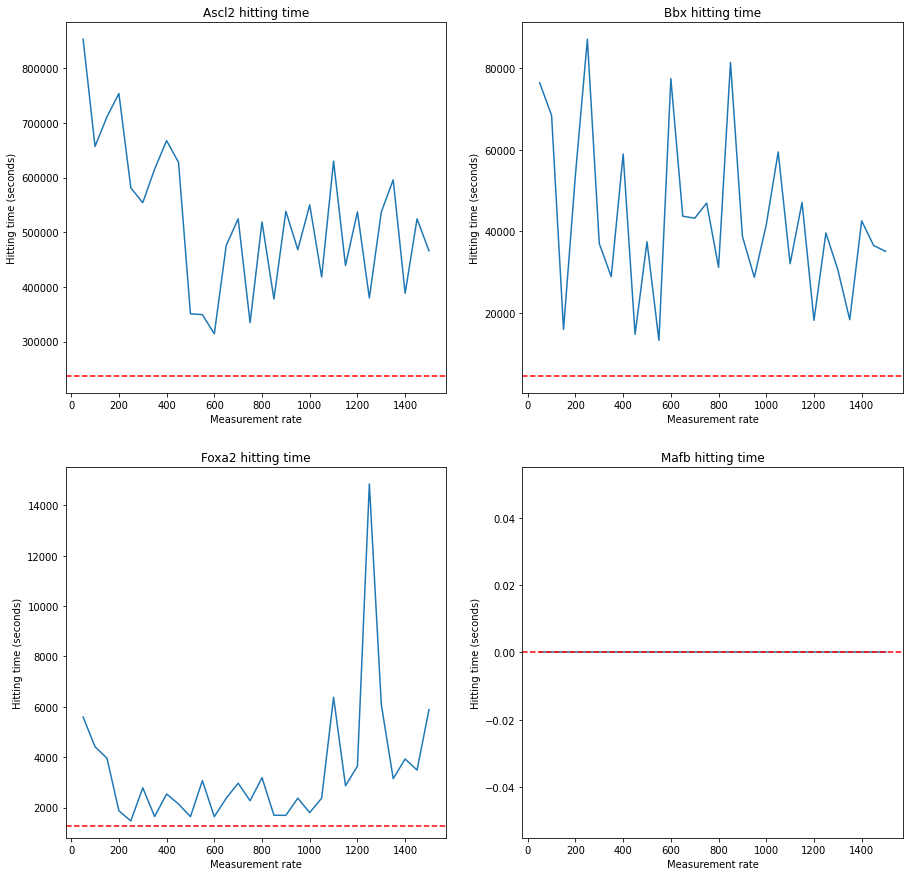

In [ ]:
plt.figure(figsize=(15,15))

for i, phen in enumerate(genotype_networks_4phen.keys()):
  plt.subplot(2,2,i+1)

  plt.plot(comparing_results.iloc[:-1]['measurement_rate'], comparing_results.iloc[:-1][f'tau_{phen} promedio'])
  plt.title(f'{phen} hitting time')
  plt.axhline(y=comparing_results[f'tau_{phen} promedio'][len(comparing_results)-1], color='red', linestyle='--', label='Classical walk')
  plt.xlabel('Measurement rate')
  plt.ylabel('Hitting time (seconds)')

plt.savefig(url_data_visualization+"Measurement rate vs hitting time.png")

# Hitting times computed with formula

We need to compute $$\mathbb{P}[S_1 = v | S_0 = u] = \mathbb{E}[p_{u,v}^T] = \mathbb{E}[|\langle v |  exp(-iTH) |u\rangle|^2],$$ where $T$ is an exponential random variable with mean equal to the measurement rate (time between measurements).

In [ ]:
def computeTransitionMatrixOfMeasurements(gspace, measurement_rate, L):
  times = expon.rvs(scale=measurement_rate, size=L) 
  
  for u in gspace.nodes:
    for v in gspace.nodes:

# Comparison of both models

## Estimations (deprecated)

In [ ]:
def updateEstimation(parameters_index):
  estimations_results['tau_prom (seconds)'][index] =  simulations_results[simulations_results['parameters_index'] == index]['tau'].mean()
  estimations_results['tau_prom (days)'][index] = estimations_results['tau_prom (seconds)'][index]/(60*24)
  # 60*24 is the number of seconds in a day
  estimations_results['N_prom'][index] = simulations_results[simulations_results['parameters_index'] == index]['N'].mean()

def updateAllEstimations():
  estimations_results = pd.DataFrame(columns=['tau_prom (seconds)', 'tau_prom (days)', 'N_prom'])

  for index, row in parameters.iterrows():
    estimation_result_aux = {}
    estimation_result_aux['tau_prom (seconds)'] =  simulations_results[simulations_results['parameters_index'] == index]['tau'].mean()
    estimation_result_aux['tau_prom (days)'] = estimation_result_aux['tau_prom (seconds)']/(60*24)
    # 60*24 is the number of seconds in a day
    estimation_result_aux['N_prom'] = simulations_results[simulations_results['parameters_index'] == index]['N'].mean()


    estimations_results = estimations_results.append(estimation_result_aux, ignore_index=True)

  return estimations_results


In [ ]:
estimations_results = updateAllEstimations()

In [ ]:
estimations_results

,tau_prom (seconds),tau_prom (days),N_prom
0,4.635340e+05,321.898631,5854.000000
1,1.401699e+06,973.401744,17517.752381
2,9.499409e+05,659.681194,11872.990000
3,3.784746e+06,2628.295600,25212.690000
4,4.990389e+05,346.554792,49896.210000
5,1.000163e+05,69.455766,100000.000000
6,1.026799e+04,7.130547,1000.000000
7,8.269004e+04,57.423636,1648.400000
8,2.481227e+05,172.307409,5000.000000
9,2.115363e+05,146.900222,4214.400000


In [ ]:
estimations_results.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CTQW_estimation_results.csv")

## Comparing

### Variables

In [ ]:
simulations = 10
last_simulations = simulations_results.tail(simulations)
last_simulations_c = simulations_results_c.tail(simulations)
resolution = "minutes"
resolution_time = 60 # number of seconds in a day, hour, etc.

In [ ]:
last_simulations['simulation time'].describe()

count    1.000000e+01
mean     1.000100e+06
std      7.378862e+01
min      1.000007e+06
25%      1.000044e+06
50%      1.000083e+06
75%      1.000151e+06
max      1.000234e+06
Name: simulation time, dtype: float64

In [ ]:
last_simulations_c['simulation time'].describe()

count    1.000000e+01
mean     1.000152e+06
std      1.566036e+02
min      1.000009e+06
25%      1.000051e+06
50%      1.000089e+06
75%      1.000193e+06
max      1.000502e+06
Name: simulation time, dtype: float64

### Read evolution paths of interest

In [ ]:
N1 = len(simulations_results)
N2 = len(simulations_results_c)
evolution_paths_c = evolutionPaths_c(range(N2-simulations, N2))
evolution_paths = evolutionPaths(range(N1-simulations, N1)) 

### Compute mutation time in quantum model

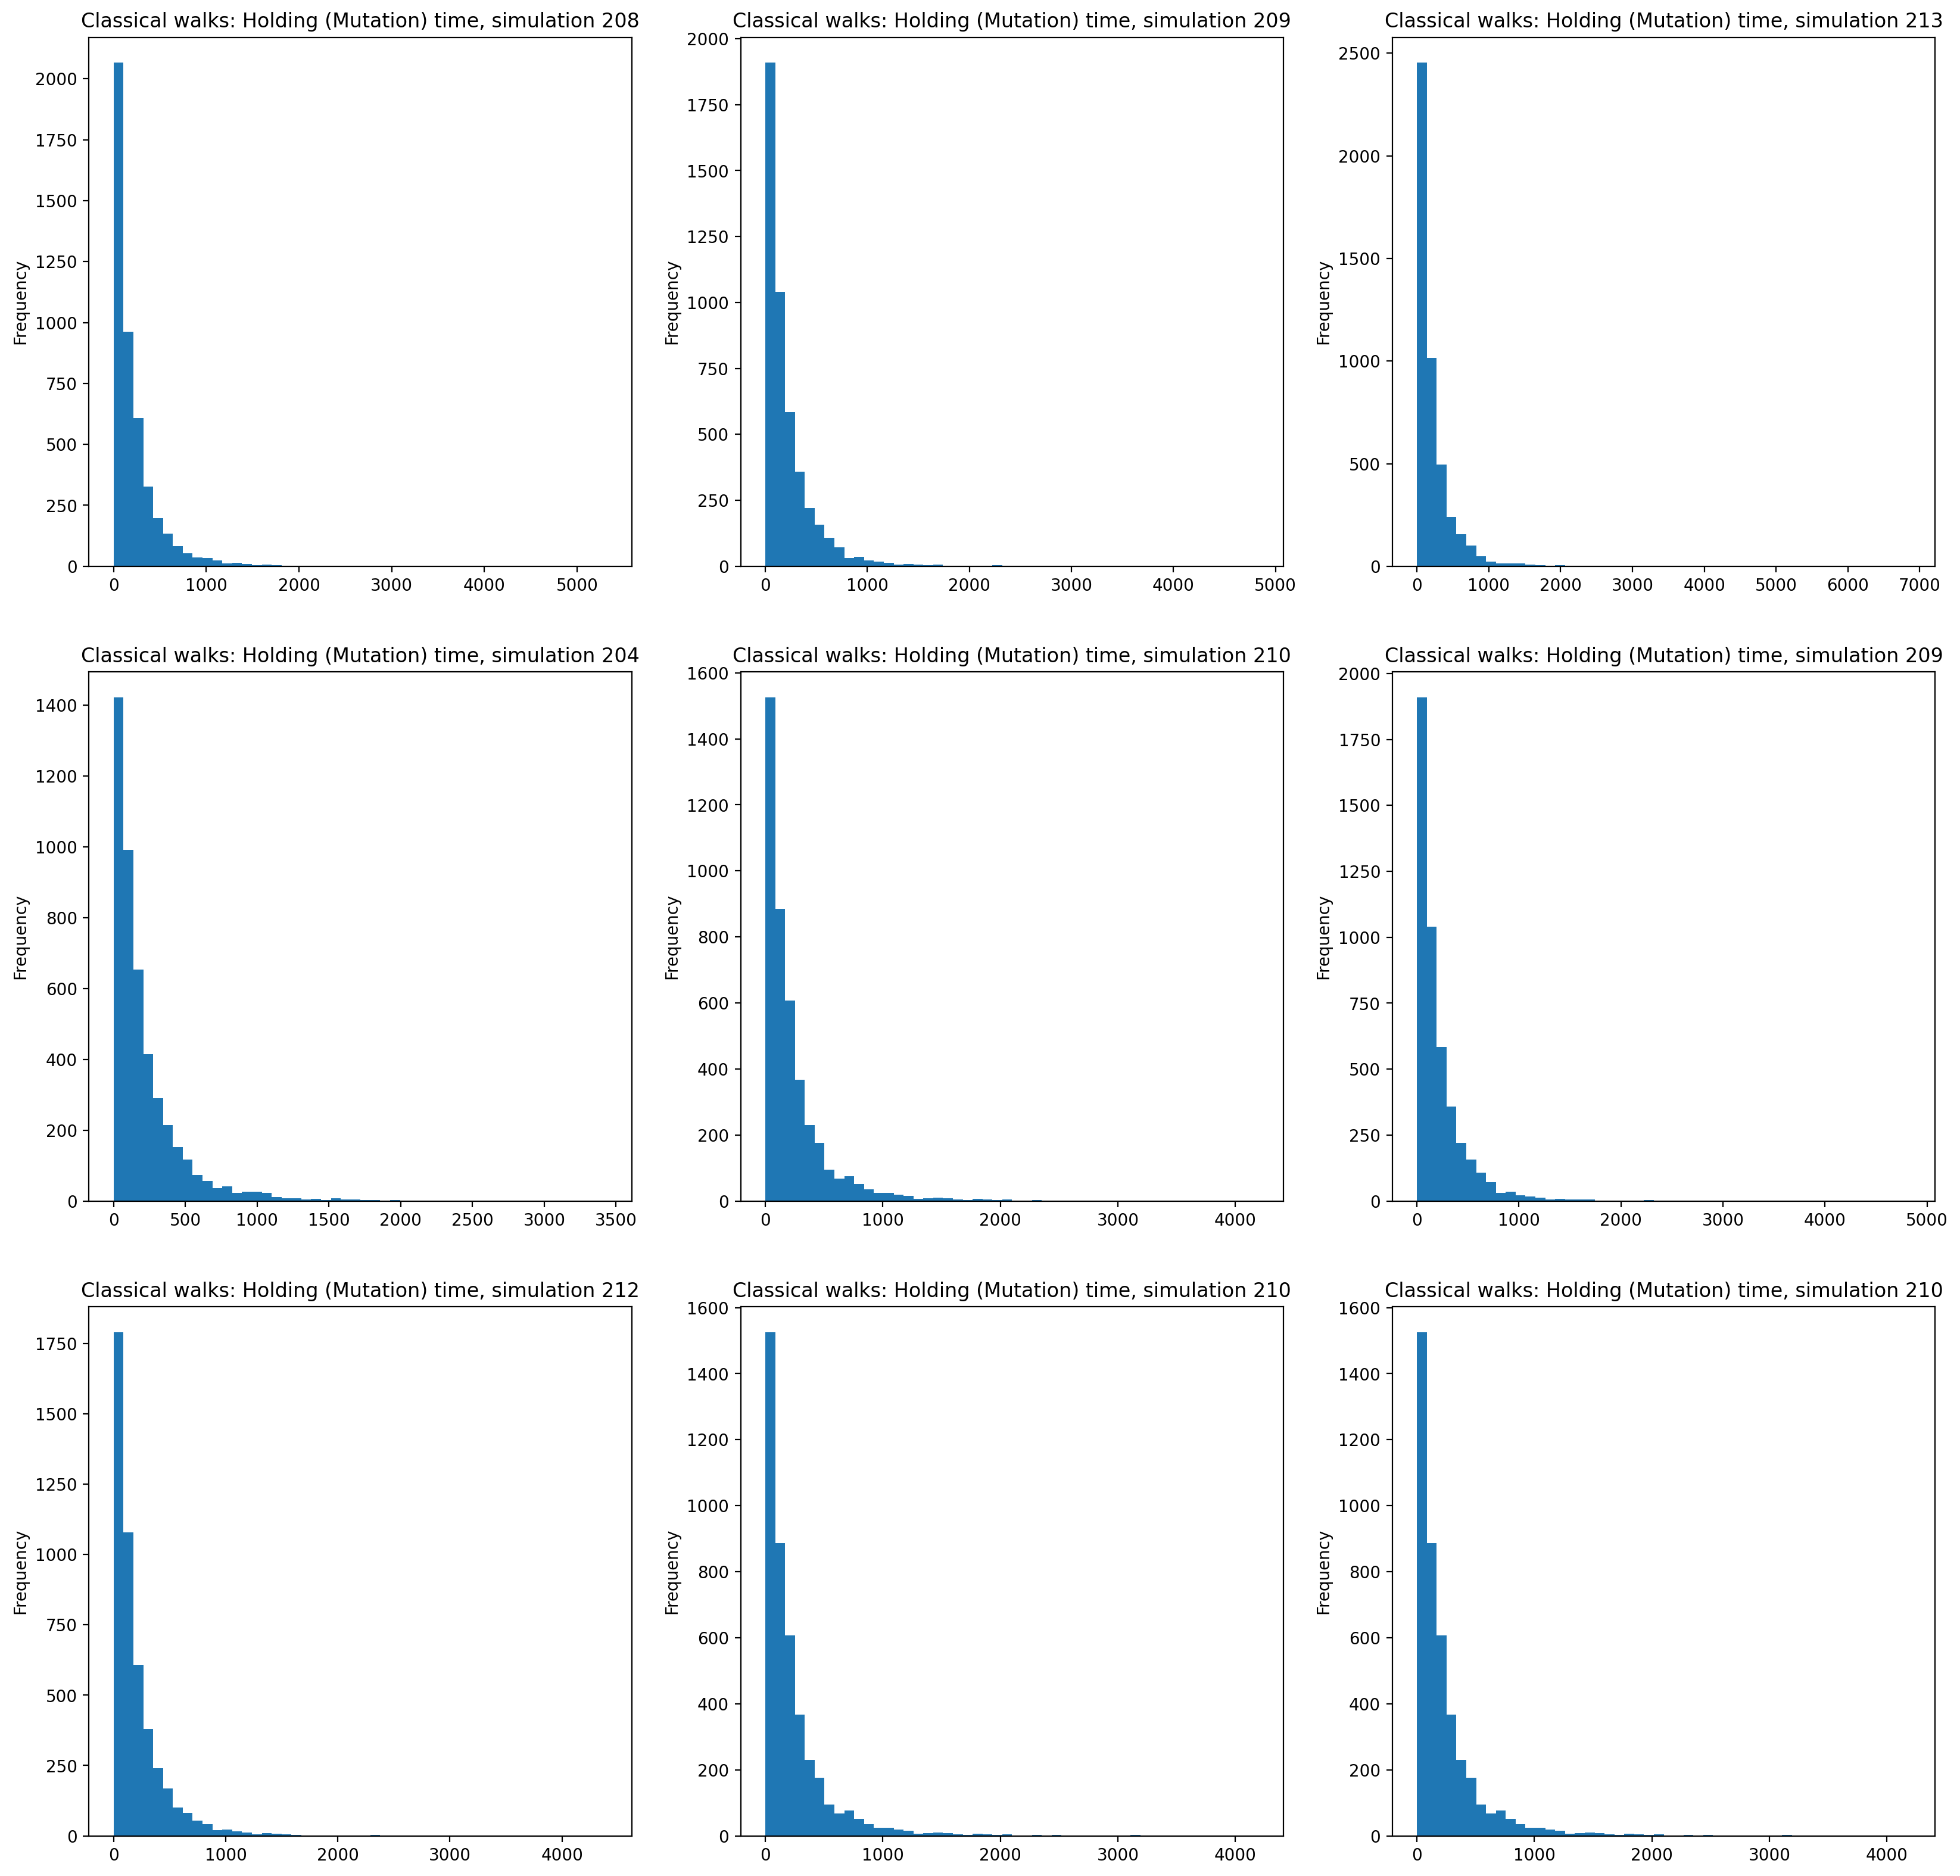

In [ ]:
plt.figure(figsize=(20,20), dpi=200)
np.random.seed(2021)

for i in range(9):
  simulation_index = np.random.choice(list(evolution_paths_c.keys()))
  plt.subplot(3,3,i+1)
  plt.title("Classical walks: Holding (Mutation) time, simulation "+str(simulation_index))
  evolution_paths_c[simulation_index]['holding time'].plot(kind="hist", bins=50)

plt.show()

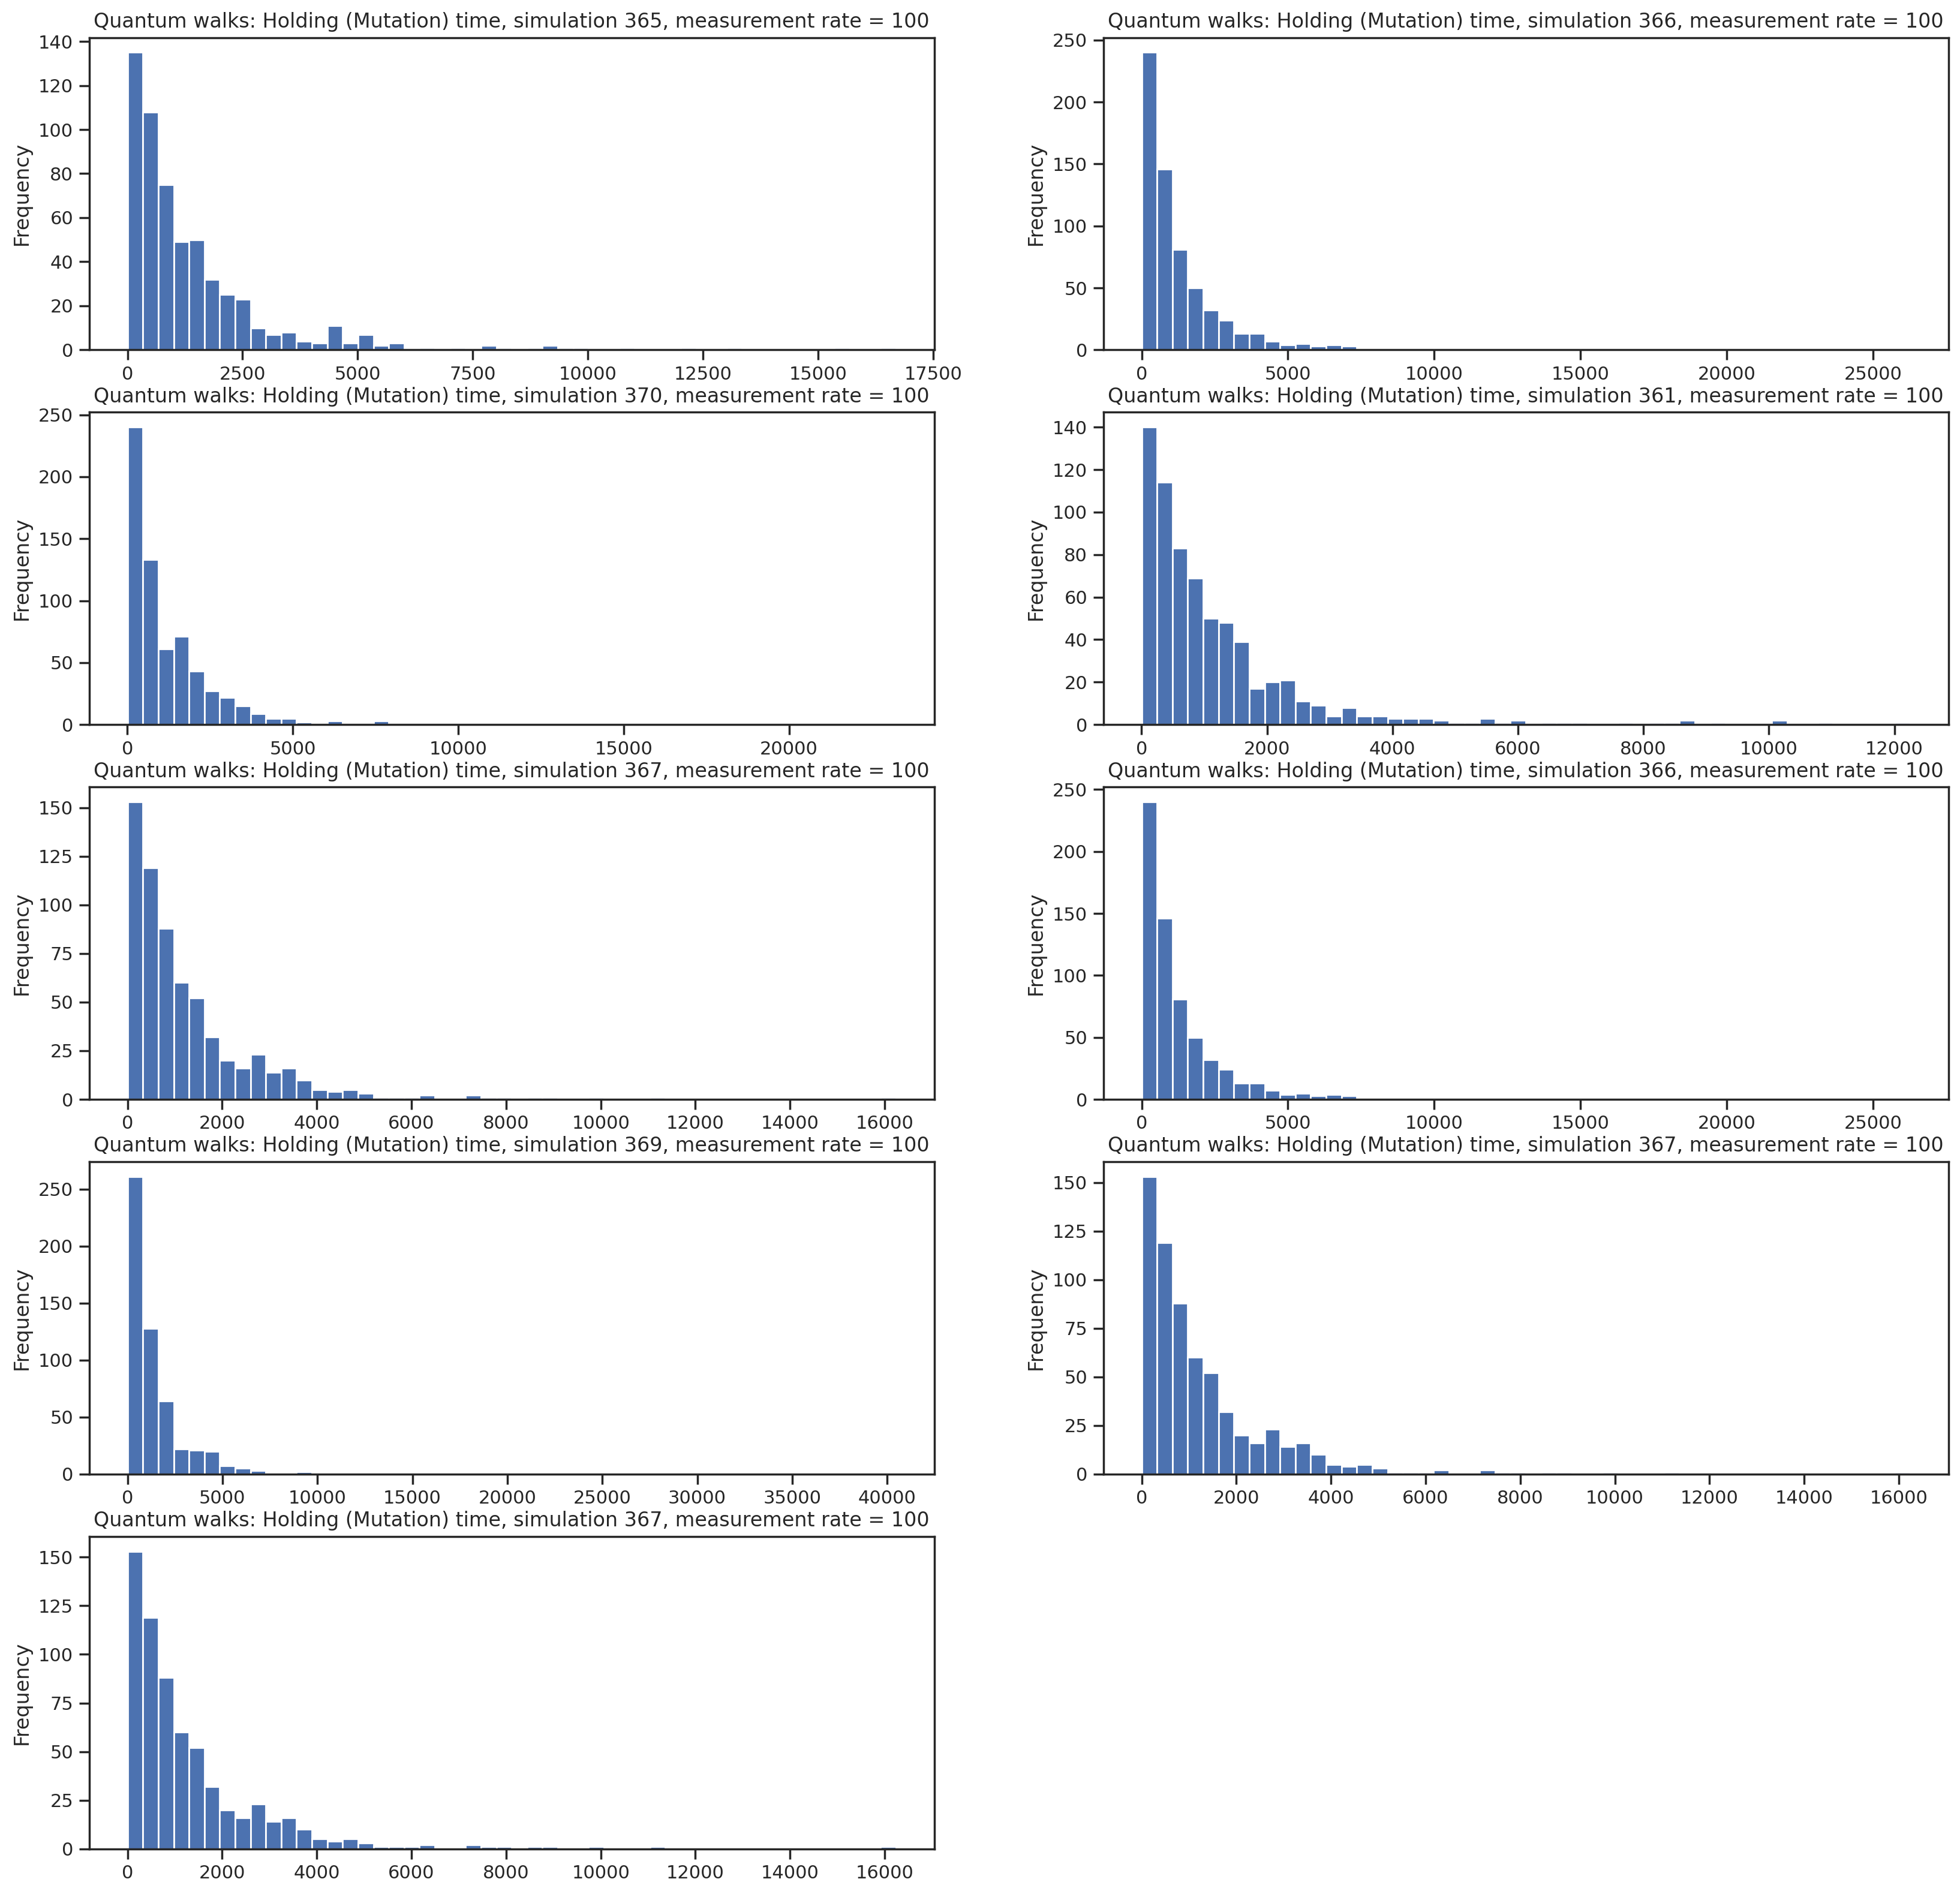

In [ ]:
plt.figure(figsize=(20,20), dpi=200)
np.random.seed(2021)

for i in range(9):
  simulation_index = np.random.choice(list(evolution_paths.keys()))
  plt.subplot(5,2,i+1)
  plt.title("Quantum walks: Holding (Mutation) time, simulation "+str(simulation_index)+", measurement rate = "+str(measurement_rate))
  evolution_paths[simulation_index][evolution_paths[simulation_index]['mutation time']>0]['mutation time'].plot(kind="hist", bins=50)

plt.show()

In [ ]:
plt.figure(figsize=(20,20), dpi=200)
np.random.seed(2021)
indices = range(351, 361)

for i in range(9):
  simulation_index = indices[i]
  plt.subplot(5,2,i+1)
  plt.title("Quantum walks: Holding (Mutation) time, simulation "+str(simulation_index)+", measurement rate = "+str(parameters['measurement_rate'][len(parameters)-2]))
  evolution_paths[simulation_index][evolution_paths[simulation_index]['mutation time']>0]['mutation time'].plot(kind="hist", bins=50)

plt.show()

### Comparison of simulation times

In [ ]:
sns.set_theme(style="ticks", color_codes=True)

In [ ]:
simulation_times = pd.DataFrame(columns=['model', 'simulation time'])

for i in last_simulations.index:
  simulation_times = simulation_times.append({'model': 'quantum', 'simulation time': 
                          simulations_results['simulation time'][i]/resolution_time}, ignore_index=True)

for i in last_simulations_c.index:
  simulation_times = simulation_times.append({'model': 'classical', 'simulation time': 
                          simulations_results_c['simulation time'][i]/resolution_time}, ignore_index=True)

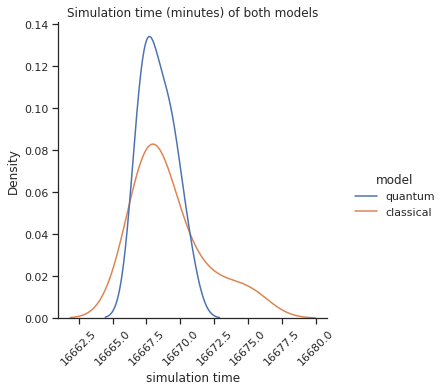

In [ ]:
#plt.figure(figsize=(15,10), dpi=60)
title = f"Simulation time ({resolution}) of both models"
g = sns.displot(x=f'simulation time', hue="model", data=simulation_times, kind="kde")
g.set(title=title)
plt.tick_params(axis='x', labelrotation=45)
plt.savefig(url_data_visualization+title+' ('+str(datetime.datetime.now())[:19]+')', bbox_inches = 'tight')
plt.show(g)

### Comparison of hitting times

In [ ]:
measurement_rate = parameters['measurement_rate'][len(parameters)-1]

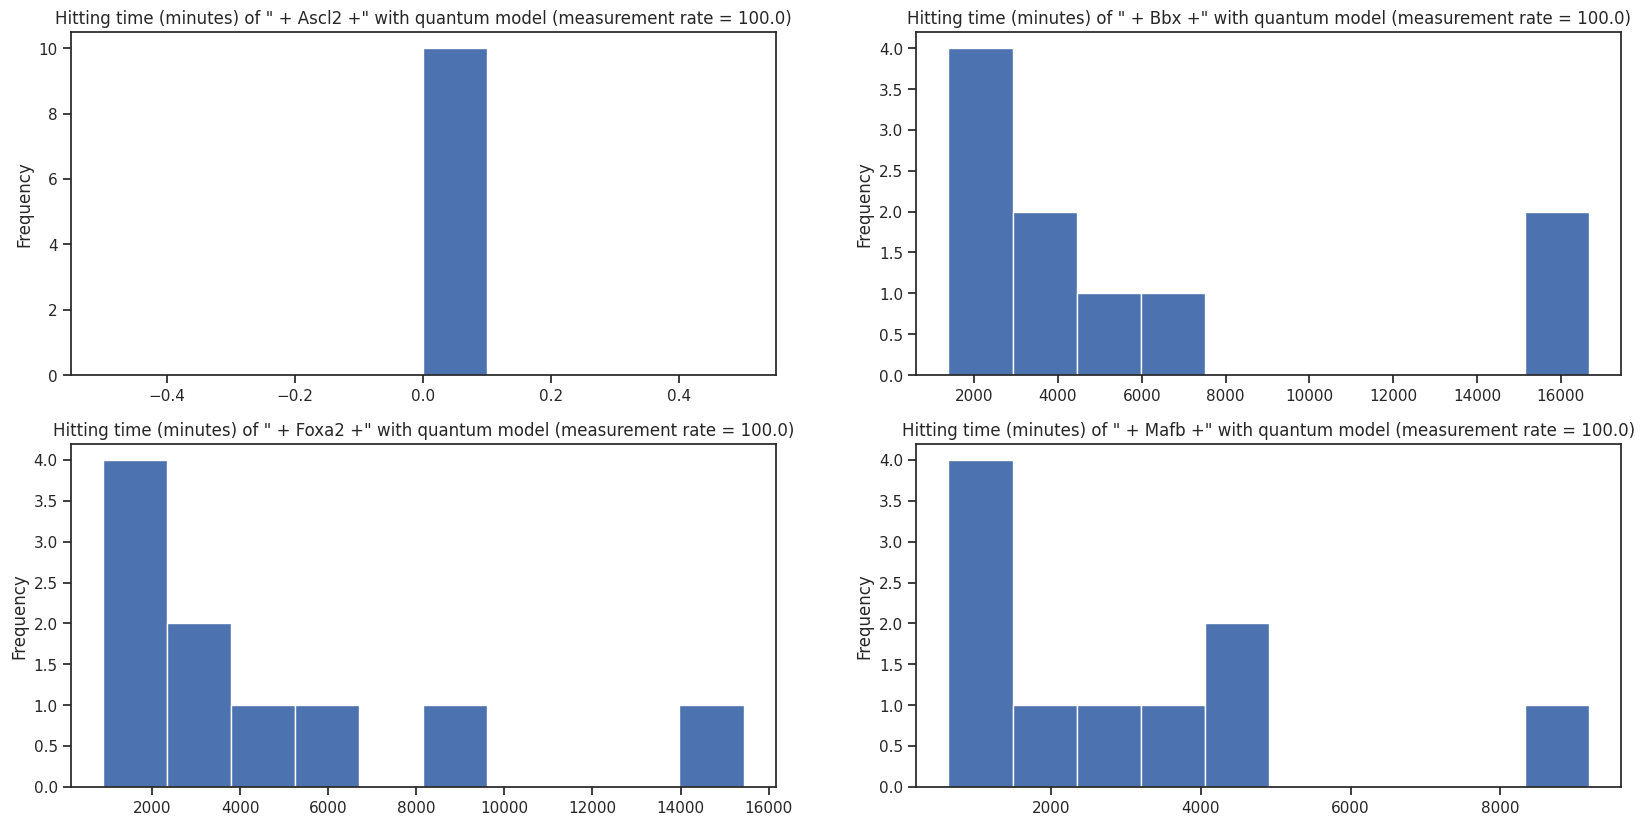

In [ ]:
plt.figure(figsize=(20,10), dpi=100)

for i, phen in enumerate(phenotypes):
  plt.subplot(2,2,i+1)
  plt.title(f'Hitting time ({resolution}) of " + {phen} +" with quantum model (measurement rate = {measurement_rate})')
  (last_simulations['tau_'+phen]/resolution_time).plot(kind="hist")

plt.show()

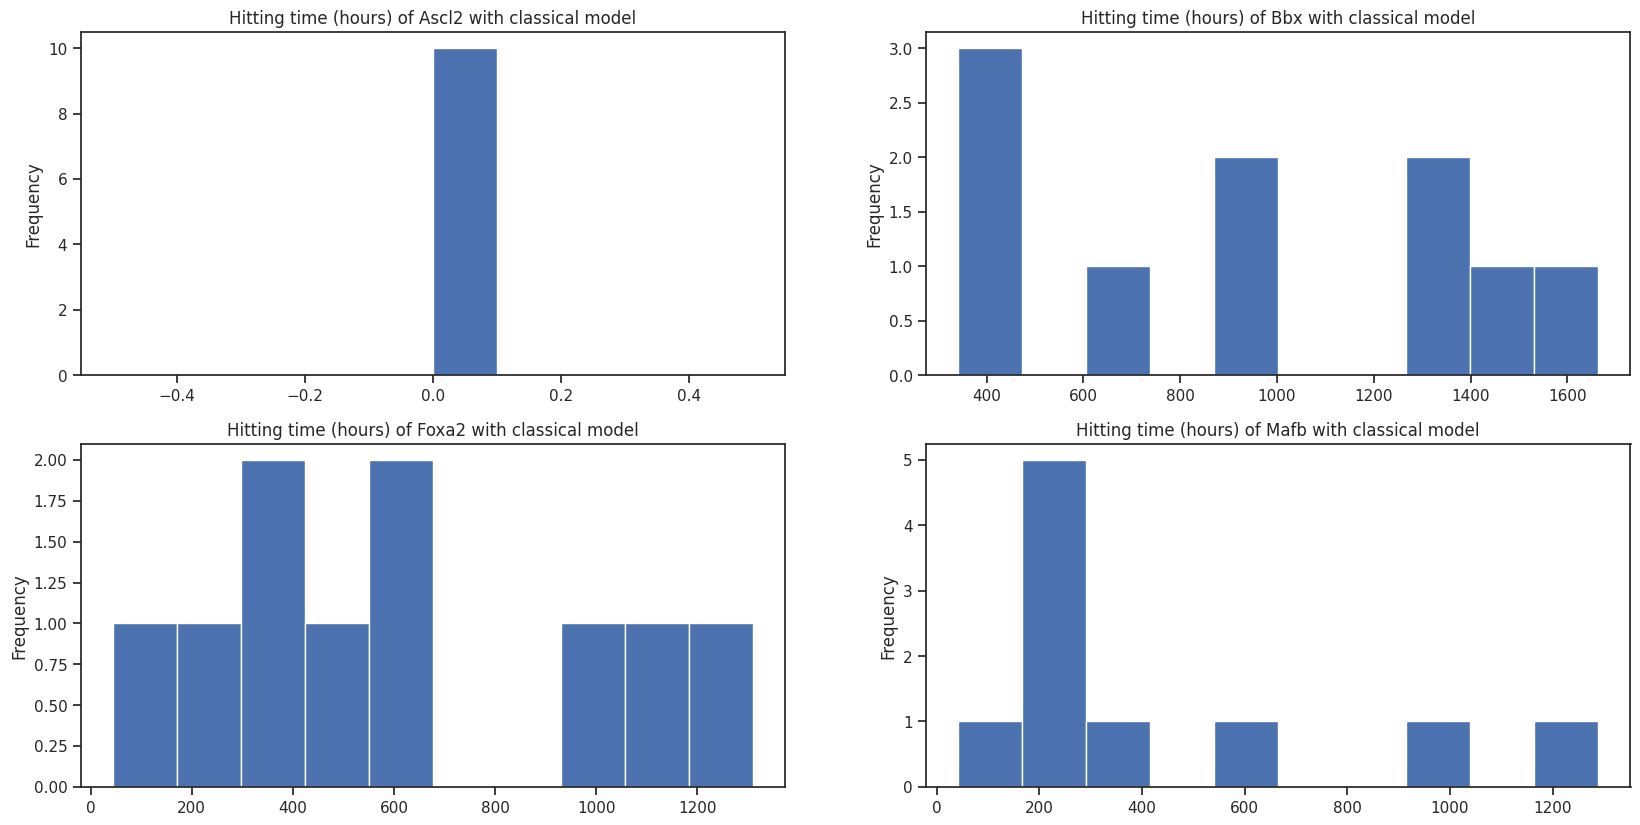

In [ ]:
plt.figure(figsize=(20,10), dpi=100)

for i, phen in enumerate(phenotypes):
  plt.subplot(2,2,i+1)
  plt.title("Hitting time (hours) of " + phen+" with classical model")
  (last_simulations_c['tau_'+phen]/(resolution_time)).plot(kind="hist")

plt.show()

Plotting categorical data with Seaborn ([click here](https://seaborn.pydata.org/tutorial/categorical.html))

In [ ]:
results = pd.DataFrame(columns=['model', 'simulation index', 'final phenotype', 'initial phenotype', 'hitting time'])
simulations_index = list(last_simulations.index)
simulations_index_c = list(last_simulations_c.index)

for i in range(simulations):
  for phen in phenotypes:
    hitting_time_phen = simulations_results['tau_'+phen][simulations_index[-1-i]]

    if hitting_time_phen > 0.0:
      results_aux = {'model': 'quantum', 'simulation index': simulations_index[-1-i], 'final phenotype': phen, 
        'initial phenotype': parameters['initial_phen'][simulations_results['parameters_index'][simulations_index[-1-i]]],
        'hitting time': hitting_time_phen/(resolution_time)}

      results = results.append(results_aux, ignore_index=True)

for i in range(simulations):
  for phen in phenotypes:
    hitting_time_phen = simulations_results_c['tau_'+phen][simulations_index_c[-1-i]]

    if hitting_time_phen > 0.0:
      results_aux = {'model': 'classical', 'simulation index': simulations_index_c[-1-i], 'final phenotype': phen, 
        'initial phenotype': parameters_c['initial_phen'][simulations_results_c['parameters_index'][simulations_index_c[-1-i]]],
        'hitting time': hitting_time_phen/(resolution_time)}

      results = results.append(results_aux, ignore_index=True)

Graph Hitting time vs final phenotype. Each dot is a random simulation which has hitting times to novel phenotypes. The graph shows the kernel density estimation of the hitting times to a given final phenotype and the scatter plot.

<Figure size 1500x600 with 0 Axes>

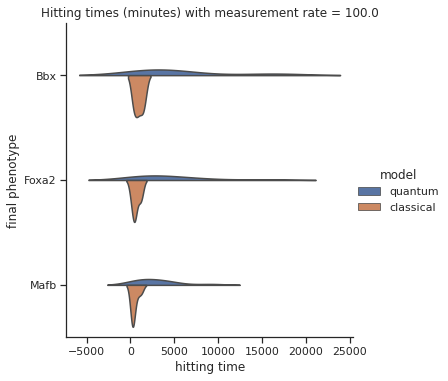

In [ ]:
plt.figure(figsize=(25,10), dpi=60)
title = f"Hitting times ({resolution}) with measurement rate = {measurement_rate}"
g = sns.catplot(x="hitting time", y="final phenotype", hue='model', kind="violin", split=True, inner=None, data=results)
g.set(title=title)
plt.savefig(url_data_visualization+title+' ('+str(datetime.datetime.now())[:19]+').png', bbox_inches = 'tight')
plt.show(g)

#### Final phenotype: Ascl2

In [ ]:
plt.figure(figsize=(25,10), dpi=60)
title = f"Hitting times ({resolution}) with measurement rate = {measurement_rate}"
g = sns.catplot(x="hitting time", y="final phenotype", hue='model', kind="violin", split=True, inner=None, data=results[(results['final phenotype']=='Ascl2')])
g.set(title=title)
plt.show(g)

ValueError: ignored

<Figure size 1500x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(25,10), dpi=60)
title = f"Hitting times ({resolution}) with measurement rate = {measurement_rate}"
g = sns.catplot(x="hitting time", y="final phenotype", hue='model', kind="swarm", data=results[(results['final phenotype']=='Ascl2')])
g.set(title=title)
plt.show(g)

#### Final phenotype: Mafb

<Figure size 1500x600 with 0 Axes>

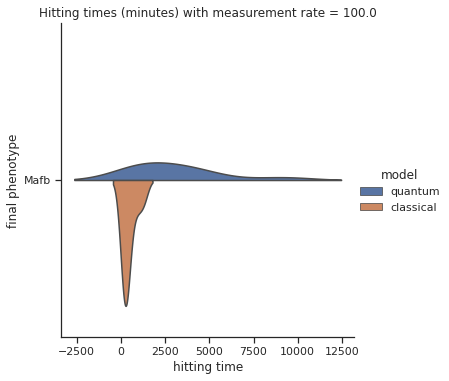

In [ ]:
plt.figure(figsize=(25,10), dpi=60)
title = f"Hitting times ({resolution}) with measurement rate = {measurement_rate}"
g = sns.catplot(x="hitting time", y="final phenotype", hue='model', kind="violin", split=True, inner=None, data=results[(results['final phenotype']=='Mafb')])
g.set(title=title)
plt.show(g)

<Figure size 1500x600 with 0 Axes>

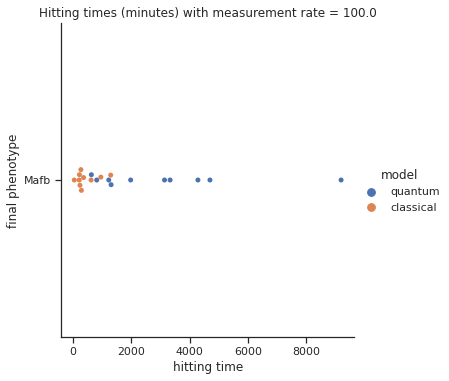

In [ ]:
plt.figure(figsize=(25,10), dpi=60)
title = f"Hitting times ({resolution}) with measurement rate = {measurement_rate}"
g = sns.catplot(x="hitting time", y="final phenotype", hue='model', kind="swarm", data=results[(results['final phenotype']=='Mafb')])
g.set(title=title)
plt.show(g)

#### Final phenotype: Foxa2

<Figure size 1500x600 with 0 Axes>

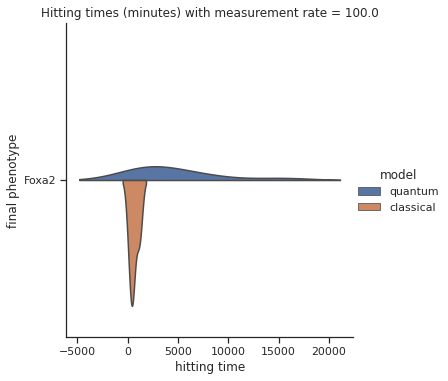

In [ ]:
plt.figure(figsize=(25,10), dpi=60)
title = f"Hitting times ({resolution}) with measurement rate = {measurement_rate}"
g = sns.catplot(x="hitting time", y="final phenotype", hue='model', kind="violin", split=True, inner=None, data=results[(results['final phenotype']=='Foxa2')])
g.set(title=title)
plt.show(g)

<Figure size 1500x600 with 0 Axes>

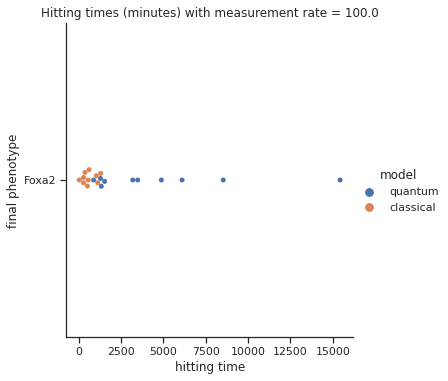

In [ ]:
plt.figure(figsize=(25,10), dpi=60)
title = f"Hitting times ({resolution}) with measurement rate = {measurement_rate}"
g = sns.catplot(x="hitting time", y="final phenotype", hue='model', kind="swarm", data=results[(results['final phenotype']=='Foxa2')])
g.set(title=title)
plt.show(g)

#### Final phenotype: Bbx

<Figure size 1500x600 with 0 Axes>

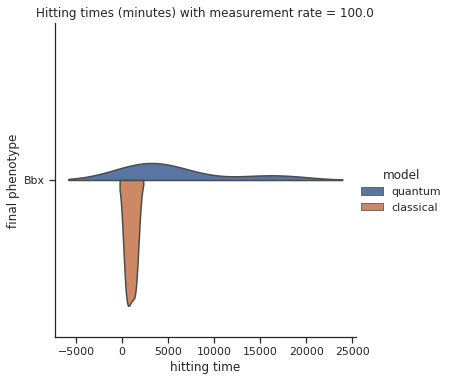

In [ ]:
plt.figure(figsize=(25,10), dpi=60)
title = f"Hitting times ({resolution}) with measurement rate = {measurement_rate}"
g = sns.catplot(x="hitting time", y="final phenotype", hue='model', kind="violin", split=True, inner=None, data=results[(results['final phenotype']=='Bbx')])
g.set(title=title)
plt.show(g)

<Figure size 1500x600 with 0 Axes>

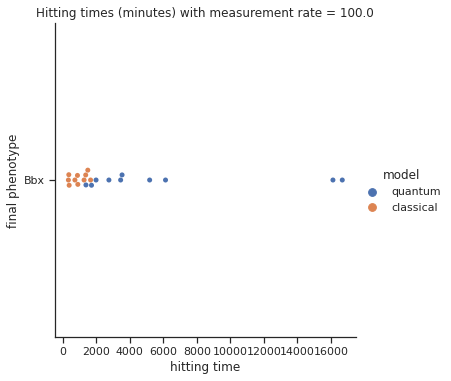

In [ ]:
plt.figure(figsize=(25,10), dpi=60)
title = f"Hitting times ({resolution}) with measurement rate = {measurement_rate}"
g = sns.catplot(x="hitting time", y="final phenotype", hue='model', kind="swarm", data=results[(results['final phenotype']=='Bbx')])
g.set(title=title)
plt.show(g)

<Figure size 2160x1440 with 0 Axes>

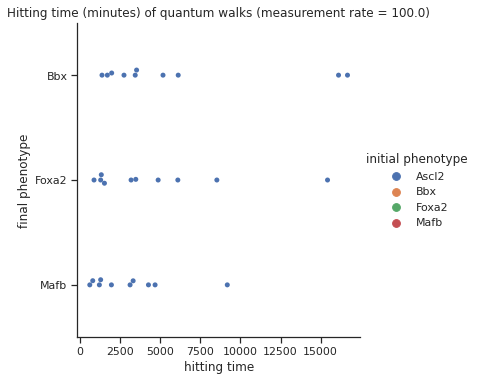

In [ ]:
plt.figure(figsize=(30,20))
title = f"Hitting time ({resolution}) of quantum walks (measurement rate = {measurement_rate})"
g = sns.catplot(kind="swarm", x="hitting time", y="final phenotype", hue='initial phenotype',
                data=results[(results['model'] == 'quantum')], hue_order=phenotypes)
g.set(title=title)
plt.savefig(url_data_visualization+title+' ('+str(datetime.datetime.now())[:19]+').png', bbox_inches = 'tight')
plt.show(g)

<Figure size 1600x800 with 0 Axes>

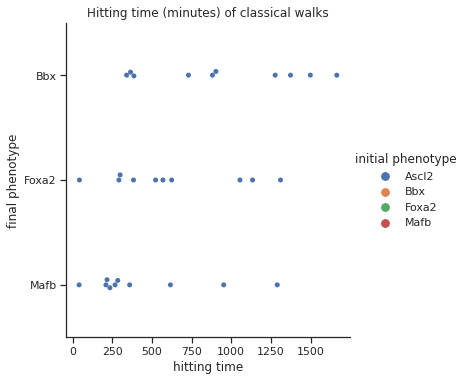

In [ ]:
plt.figure(figsize=(20,10), dpi=80)
title = f"Hitting time ({resolution}) of classical walks"
g = sns.catplot(kind="swarm", x="hitting time", y="final phenotype", hue='initial phenotype', 
      data=results[results['model'] == 'classical'], hue_order=phenotypes)
g.set(title=title)
plt.savefig(url_data_visualization+title+' ('+str(datetime.datetime.now())[:19]+').png', bbox_inches = 'tight')
plt.show(g)

In [ ]:
parameters.tail(20)

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate,max_simulation_time
188,Ascl2,CAGCTGCG,57,-1.0,500.0,0.001,1000000
189,Bbx,TTATGAAA,128,-1.0,500.0,0.001,1000000
190,Ascl2,ACAGCTGT,44,-1.0,500.0,0.001,1000000
191,Mafb,ACCAAAAA,511,-1.0,500.0,0.001,1000000
192,Mafb,TGAAAAAA,533,-1.0,500.0,0.001,1000000
193,Foxa2,CCAAATAA,349,-1.0,500.0,0.001,1000000
194,Foxa2,GACAAACA,152,-1.0,500.0,0.001,1000000
195,Foxa2,AAAACAAT,396,-1.0,500.0,0.001,1000000
196,Mafb,TGTGAAAA,502,-1.0,500.0,0.001,1000000
197,Foxa2,TATACATA,198,-1.0,500.0,0.001,1000000


In [ ]:
parameters_c.tail(20)

,initial_phen,initial_gen,initial_gen_index,max_jumps,transition_rate,max_simulation_time
137,Foxa2,GGGTAAAC,341,-1,0.001,1000000
138,Ascl2,CAGCTGCG,57,-1,0.001,1000000
139,Bbx,TTATGAAA,128,-1,0.001,1000000
140,Ascl2,ACAGCTGT,44,-1,0.001,1000000
141,Mafb,ACCAAAAA,511,-1,0.001,1000000
142,Mafb,TGAAAAAA,533,-1,0.001,1000000
143,Foxa2,CCAAATAA,349,-1,0.001,1000000
144,Foxa2,GACAAACA,152,-1,0.001,1000000
145,Foxa2,AAAACAAT,396,-1,0.001,1000000
146,Mafb,TGTGAAAA,502,-1,0.001,1000000
